# Imports

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from time import time
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_curve


# Models Used
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier

sns.set_theme(style="whitegrid")


# Loading Data from external sources

In [2]:
# Old Excel file
# churn_data = pd.read_csv('/content/drive/MyDrive/HUA/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

# churn_data = pd.read_excel('/content/drive/MyDrive/HUA/CustomerChurn.xlsx', index_col='Customer ID')
# churn_telco = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn.xlsx', index_col='CustomerID')
# churn_demograph = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_demographics.xlsx', index_col='Customer ID') # joined
# churn_location = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_location.xlsx', index_col='Customer ID') # joined
# churn_pop = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_population.xlsx', index_col='Zip Code') # joined
# churn_services = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_services.xlsx', index_col='Customer ID') # joined
# churn_status = pd.read_excel('/content/drive/MyDrive/HUA/Telco_customer_churn_status.xlsx', index_col='Customer ID')


In [12]:
# Old Excel file
# churn_data = pd.read_csv('/content/drive/MyDrive/HUA/WA_Fn-UseC_-Telco-Customer-Churn.csv', index_col='customerID')

churn_data = pd.read_excel('CustomerChurn.xlsx', index_col='Customer ID')
churn_telco = pd.read_excel('Telco_customer_churn.xlsx', index_col='CustomerID')
churn_demograph = pd.read_excel('Telco_customer_churn_demographics.xlsx', index_col='Customer ID') # joined
churn_location = pd.read_excel('Telco_customer_churn_location.xlsx', index_col='Customer ID') # joined
churn_pop = pd.read_excel('Telco_customer_churn_population.xlsx', index_col='Zip Code') # joined
churn_services = pd.read_excel('Telco_customer_churn_services.xlsx', index_col='Customer ID') # joined
churn_status = pd.read_excel('Telco_customer_churn_status.xlsx', index_col='Customer ID')

## Taking a look for null values and dtypes

In [3]:
# churn_telco.info()
# churn_demograph.info()
# churn_location.info()
# churn_pop.info()
# churn_services.info()
# churn_status.info()


## Joining Data

In [26]:
demographic_cols = ['Gender','Age', 'Under 30', 'Married', 'Number of Dependents']
churn_data_no_total_charges = churn_data.drop(columns='Total Charges')

# Joining demographic data
updated_churn_data = churn_data_no_total_charges.join(churn_demograph[demographic_cols])

# Joining location data to help join population data
churn_with_loc = updated_churn_data.join(churn_location[['Zip Code', 'Latitude', 'Longitude', 'City']])

# Joining population data
updated_churn_data_zip = churn_with_loc.join(churn_pop, on='Zip Code')

# Calculating new column population to state population ration
updated_churn_data_zip['Population Percentage'] = updated_churn_data_zip['Population'] * 100 / 38940231

# Joining services data
services_columns_drop = ['Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 
                         'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
churn_wservices = updated_churn_data_zip.join(churn_services.drop(services_columns_drop, axis=1))

# Droping column from final dataset
final_dataset = churn_wservices.drop(columns=['LoyaltyID', 'ID', 'Service ID', 'Count', 'Quarter'])



# Preprocessing and Transforming Data and Visualization

- Filling Offer and Internet Type columns null values with 'No Offer' and 'No Internet'
- Converting all the columns with Yes/No value to 0/1 except Churn
- Replacing ',' with '.' to transform values to float

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

def mapYesNo(df):
  yes_no_dict = {'No': 0, 'Yes': 1}
  for col in df.columns:
    if set(df[col].unique()) == set(['No', 'Yes']) and col != 'Churn':
      df[col] = df[col].map(yes_no_dict)
  return df

final_dataset['Offer'] = final_dataset['Offer'].fillna('No Offer')
final_dataset['Internet Type'] = final_dataset['Internet Type'].fillna('No Internet')

final_dataset = mapYesNo(final_dataset)
final_dataset['Total Charges'] = final_dataset['Total Charges'].replace(',', '.')
final_dataset['Total Charges'] = final_dataset['Total Charges'].astype(np.float16)



c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 14.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 16.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


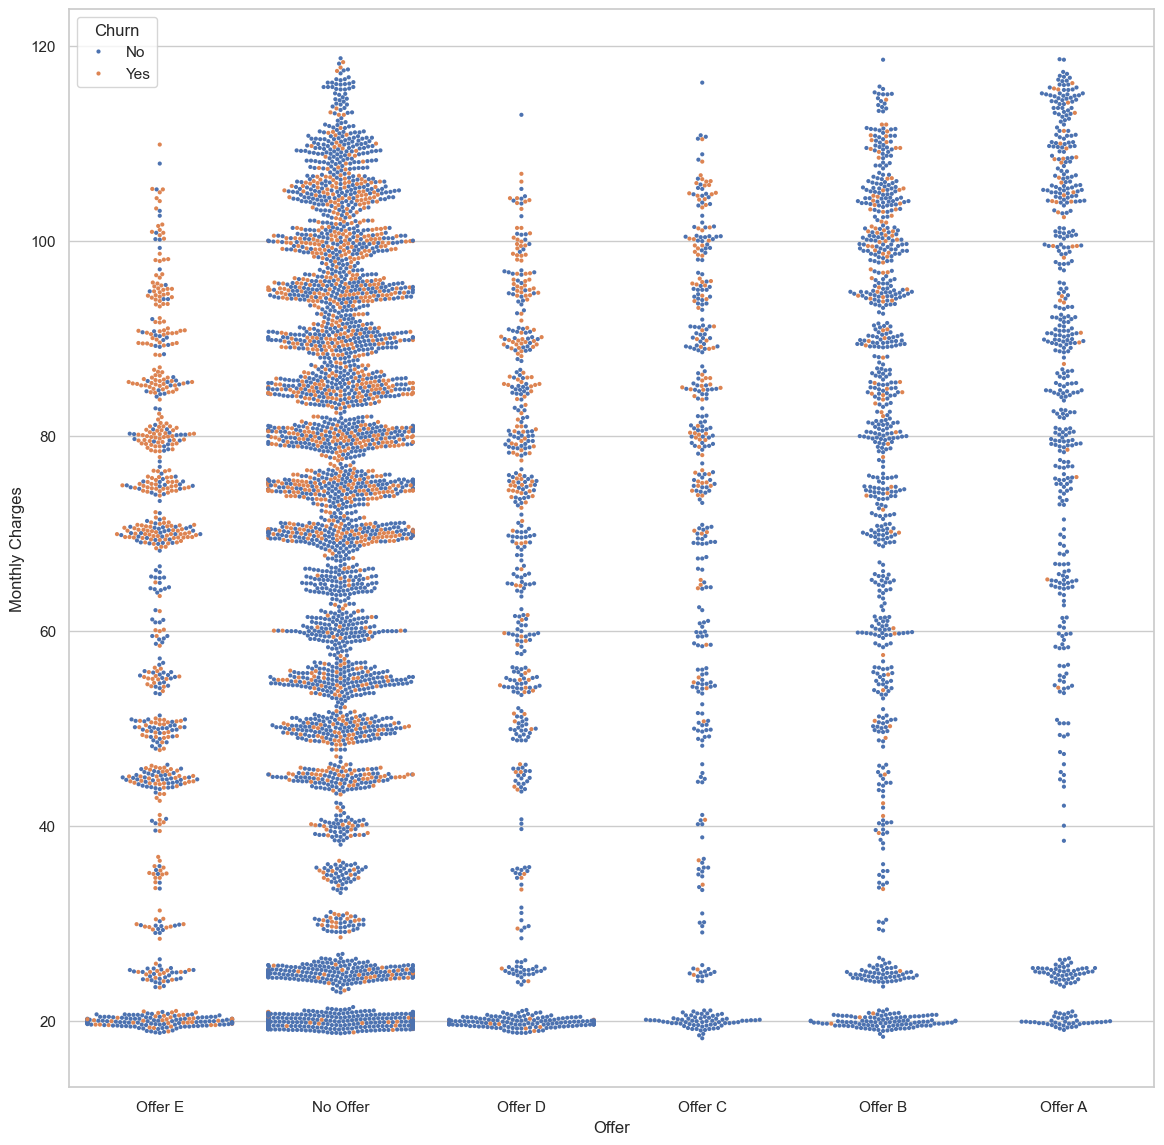

In [15]:
plt.figure(figsize=(14, 14))
sns.swarmplot(final_dataset, x='Offer', y='Monthly Charges', size=3, hue='Churn')
plt.show()

### Ploting a joinplot to see where most people leave

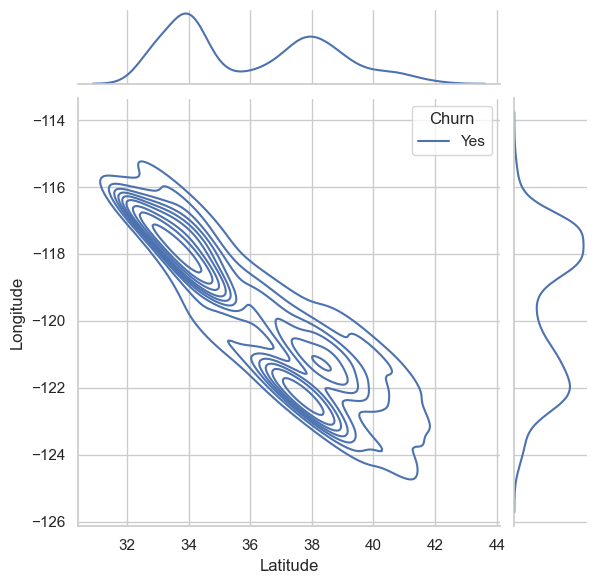

In [103]:
sns.jointplot(data=final_dataset[final_dataset['Churn'] == 'Yes'], x="Latitude", y="Longitude", hue="Churn", kind="kde")

### Plotting numeric columns to find patterns

Tenure


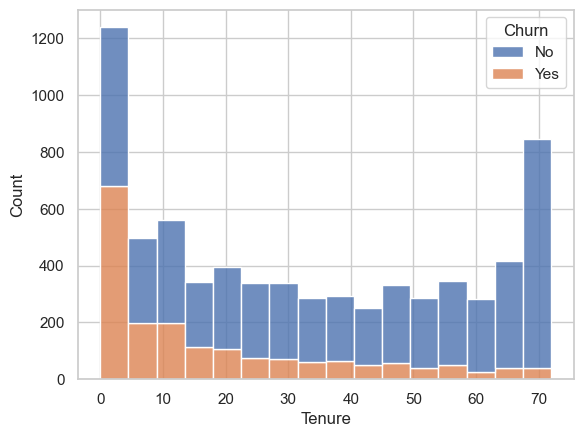

Monthly Charges


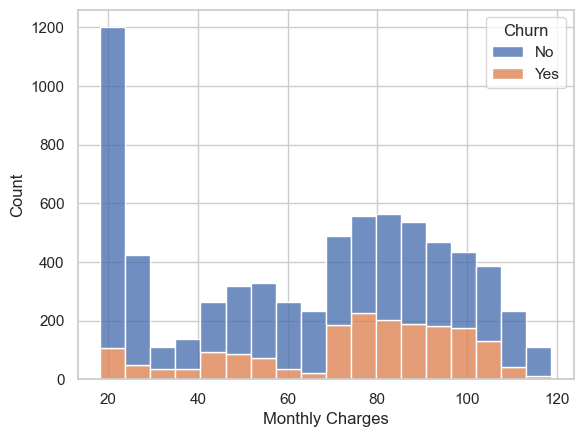

Age


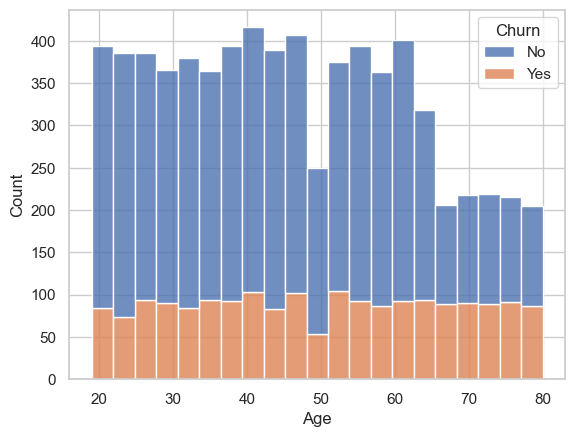

Number of Dependents


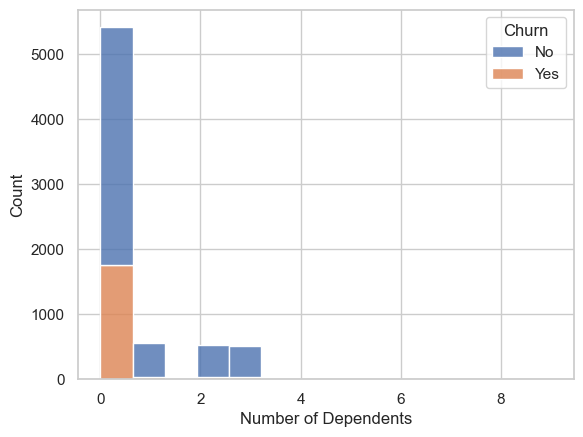

Zip Code


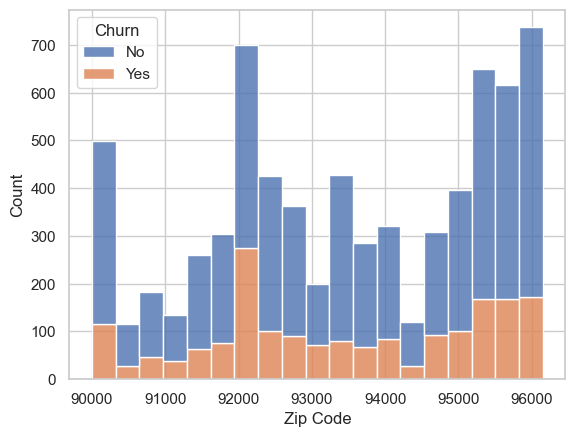

Latitude


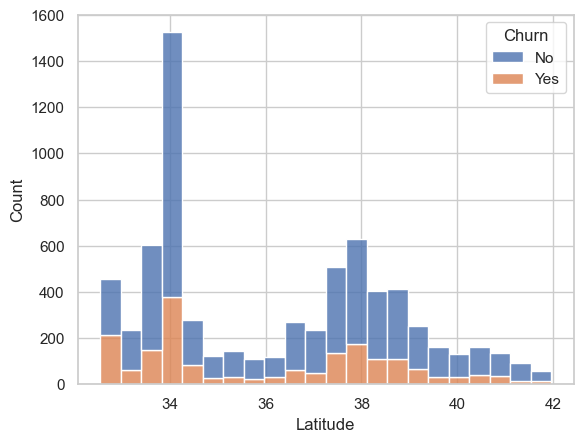

Longitude


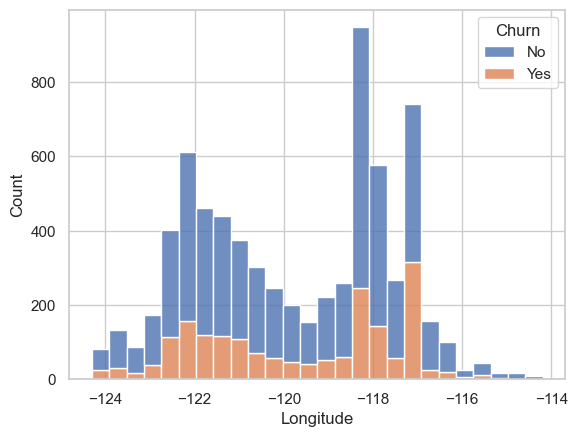

Population


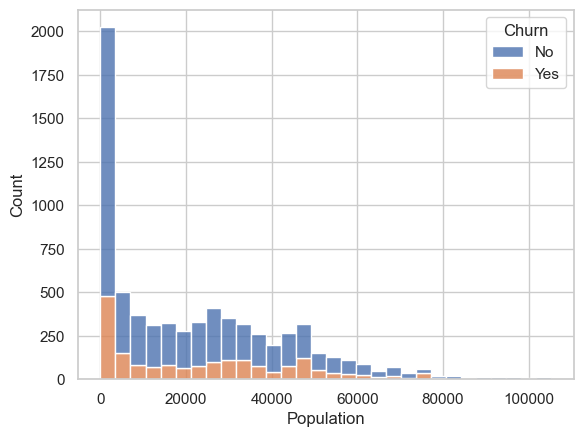

Population Percentage


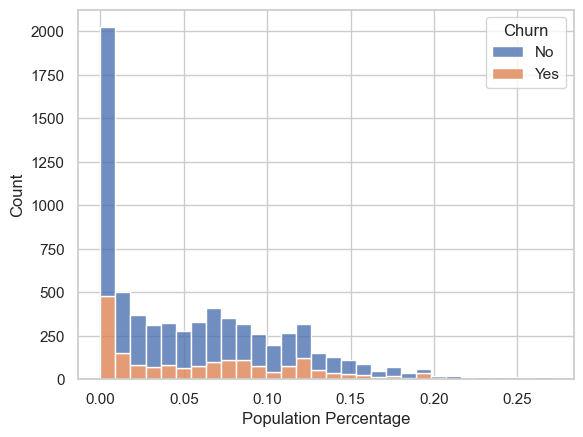

Number of Referrals


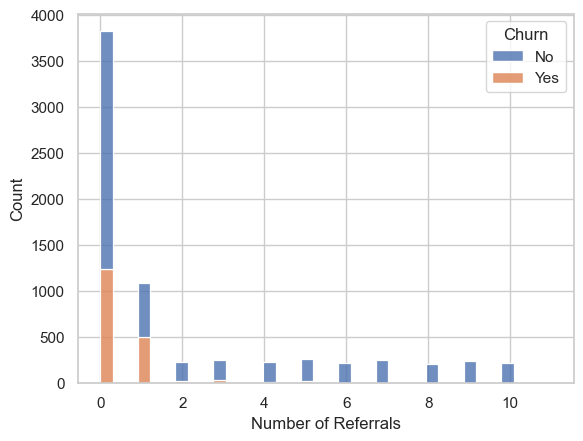

Tenure in Months


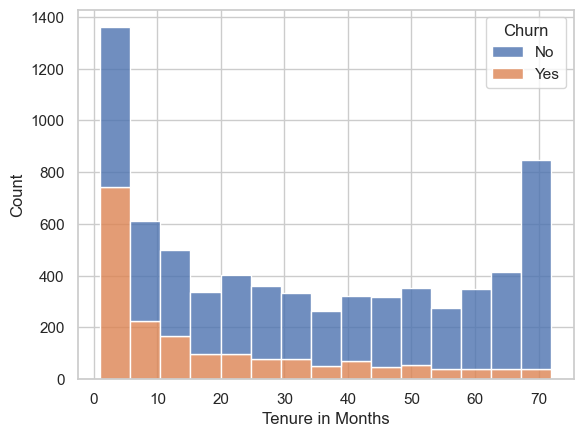

Avg Monthly Long Distance Charges


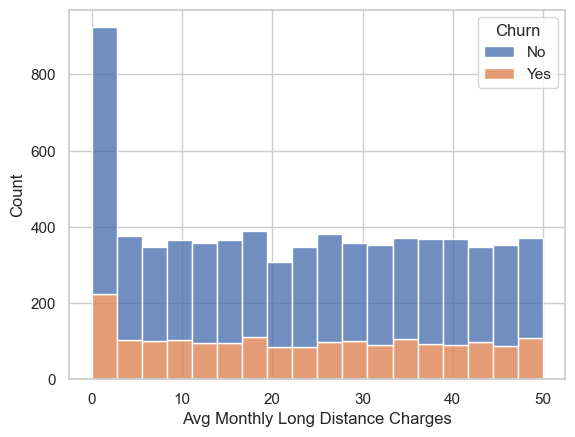

Avg Monthly GB Download


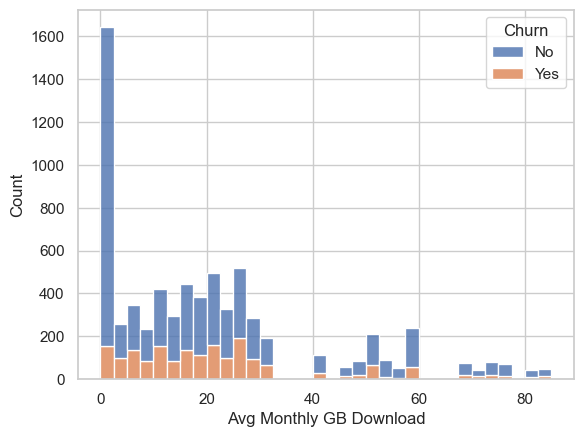

Monthly Charge


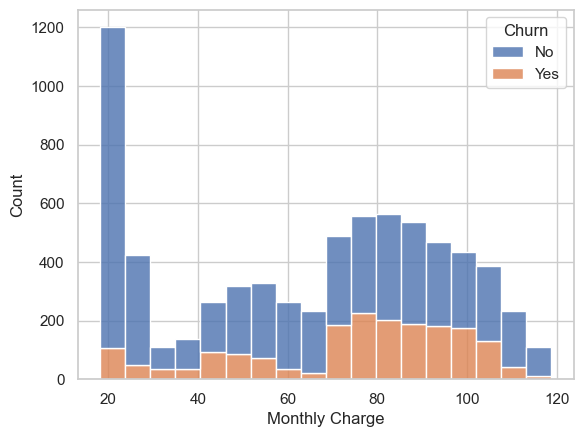

Total Charges


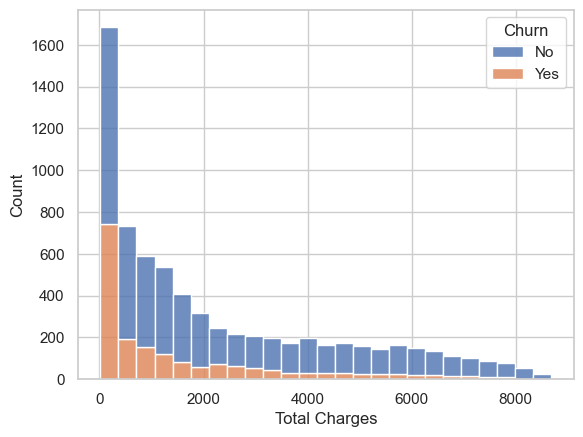

Total Long Distance Charges


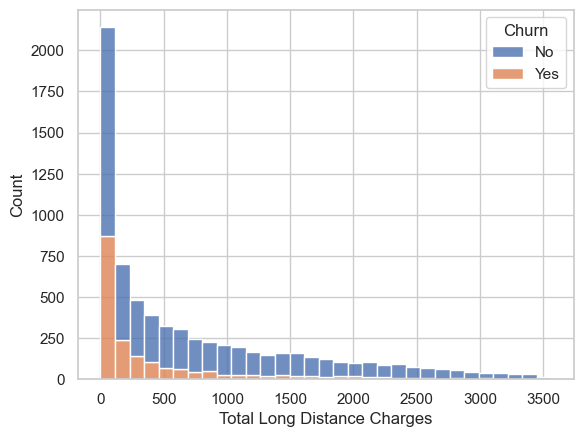

Total Revenue


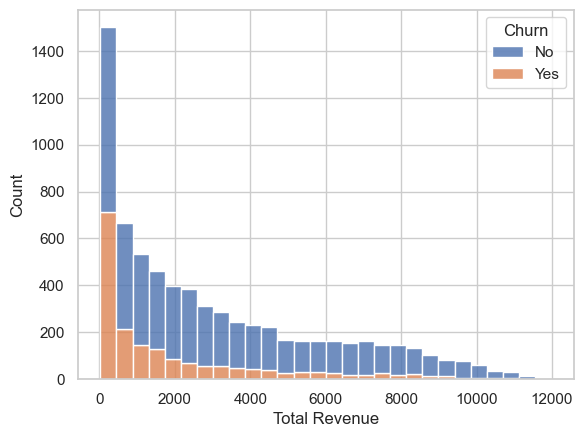

In [76]:
dropped_columns = ['Total Refunds', 'Total Extra Data Charges']
for column in final_dataset.select_dtypes('number').drop(columns=dropped_columns).columns:
  print(column)
  # plt.figure(figsize=(10, 10))
  sns.histplot(final_dataset, x=column, 
              hue='Churn', 
              multiple='stack',             
              alpha=0.8)  
  plt.show()

### Plotting the coordination points and checking if there is a pattern of churn value

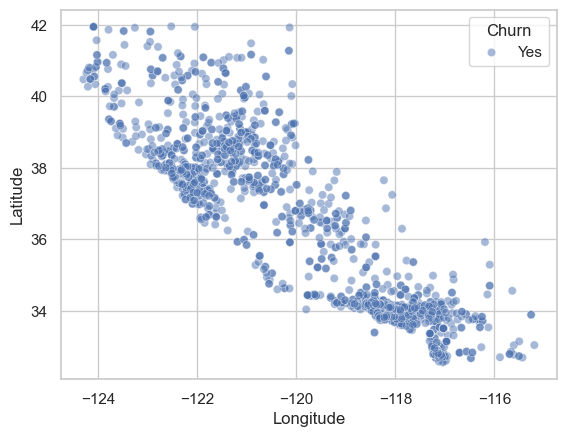

In [72]:
# plt.figure(figsize=(10, 7))
sns.scatterplot(final_dataset[final_dataset['Churn'] == 'Yes'], x='Longitude', y='Latitude', alpha=.5, hue='Churn')
plt.show()

### Plotting cities to find patterns for churn

<Axes: xlabel='City', ylabel='count'>

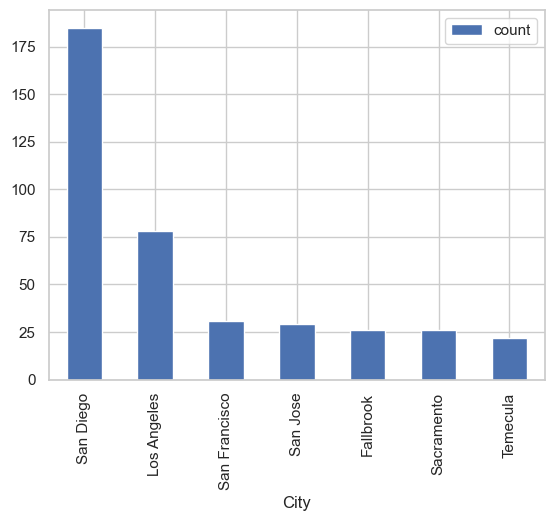

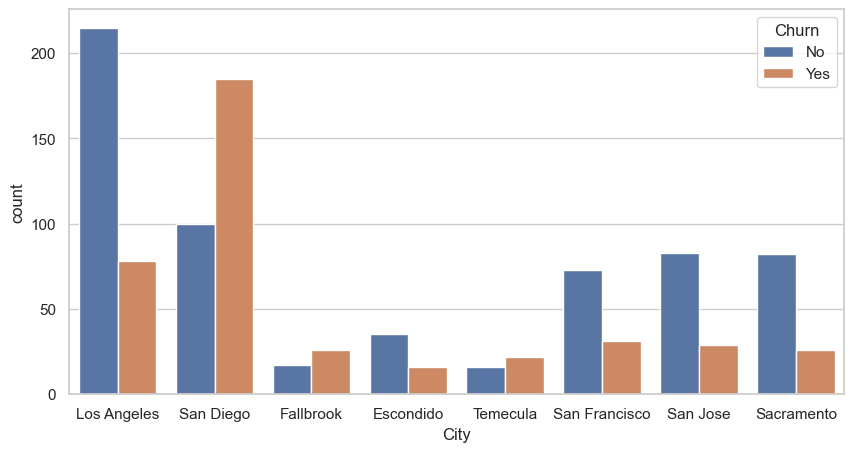

In [110]:
group_by_zip_people = final_dataset.groupby(by='City')['Churn'].count().reset_index()
group_by_zip_churn_type = final_dataset.groupby(by='City')['Churn'].value_counts().reset_index()
group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(7).plot(kind='bar', x='City', y='count')
cities_with_high_samples = group_by_zip_churn_type[group_by_zip_churn_type.Churn == 'Yes'].sort_values(by='count', ascending=False).head(8)['City'].to_list()
plt.figure(figsize=(10, 5))
sns.countplot(final_dataset[final_dataset['City'].isin(cities_with_high_samples)], x='City', hue='Churn')


Dropping Columns that will not be needed for for the machine learning algorithms

In [116]:
duplicate_not_needed_columns = ['Zip Code', 'Monthly Charge', 'Internet Service']
final_dataset = final_dataset.drop(columns=duplicate_not_needed_columns, errors='ignore')

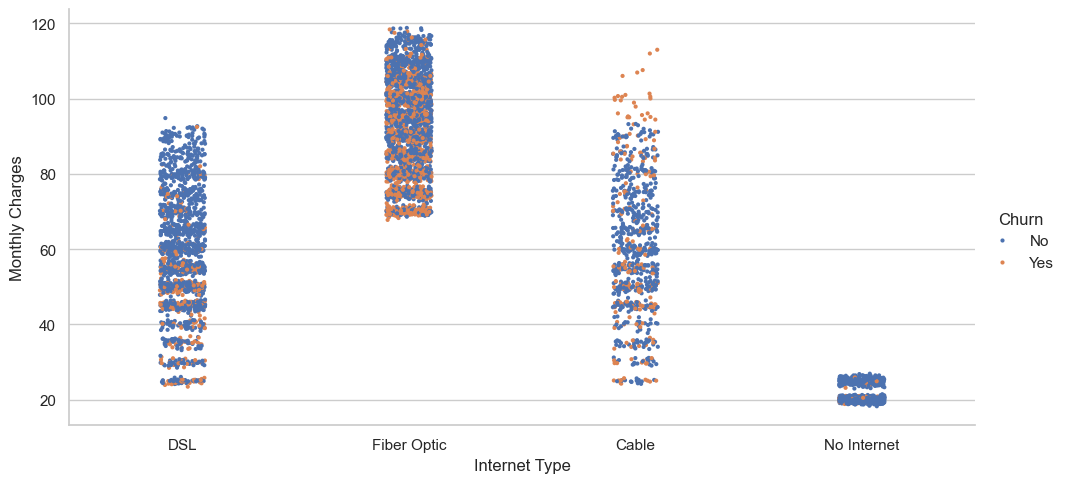

In [19]:
colName = "Internet Type"

g = sns.catplot(
    data=final_dataset, x=colName, y="Monthly Charges", hue="Churn",
    height=5, aspect=2, size=3
    )
g.set_axis_labels(colName, "Monthly Charges")
g.set_xticklabels(final_dataset[colName].unique())
g.set_titles("{col_name} {col_var}")


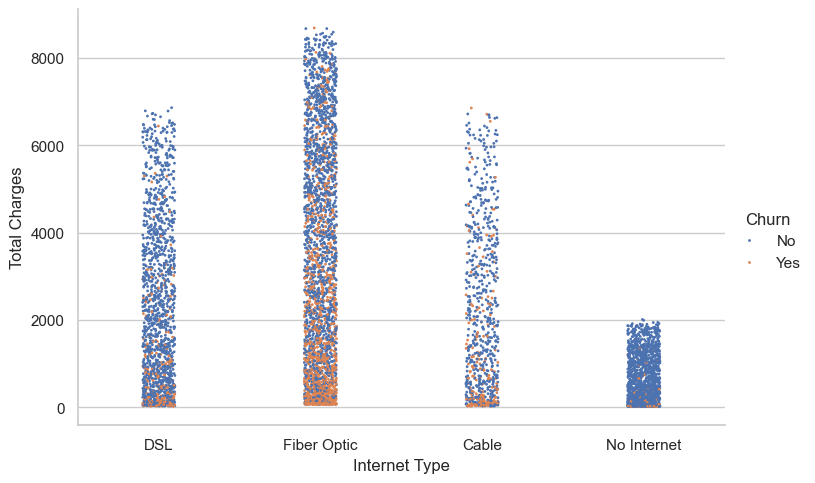

In [20]:

colName2 = 'Internet Type'

g = sns.catplot(
    data=final_dataset,
    x=colName2,
    y="Total Charges",
    hue="Churn",
    height=5,
    aspect=1.5,
    size=2
    )
g.set_axis_labels(colName2, "Total Charges")
g.set_xticklabels(final_dataset[colName2].unique())
g.set_titles("{col_name} {col_var}")



Plotting Total Refunds 0 and the rest of the values separately because of change of scale

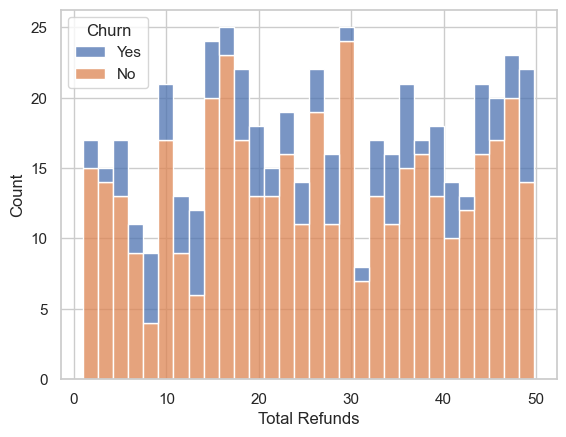

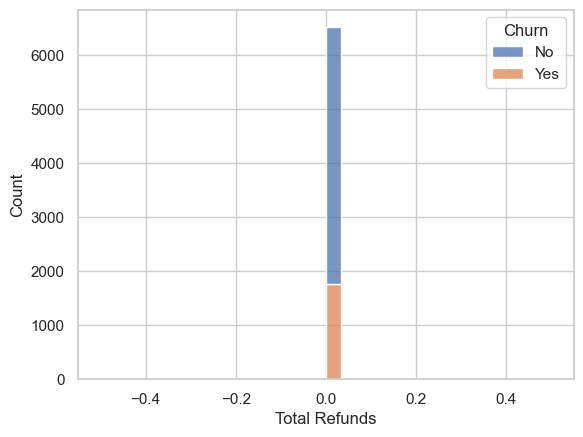

In [122]:
column_to_plot = 'Total Refunds'
sns.histplot(final_dataset[final_dataset[column_to_plot] != 0], x=column_to_plot, bins=30, hue='Churn',  multiple="stack")
plt.show()
print('\n')

sns.histplot(final_dataset[final_dataset[column_to_plot] == 0], x=column_to_plot, bins=30, hue='Churn',  multiple="stack" )
plt.show()
print('\n')

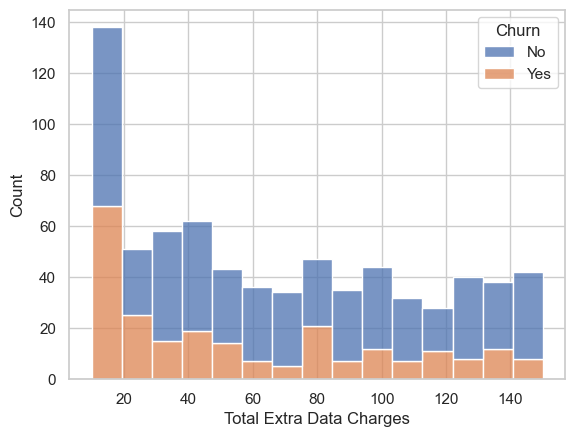

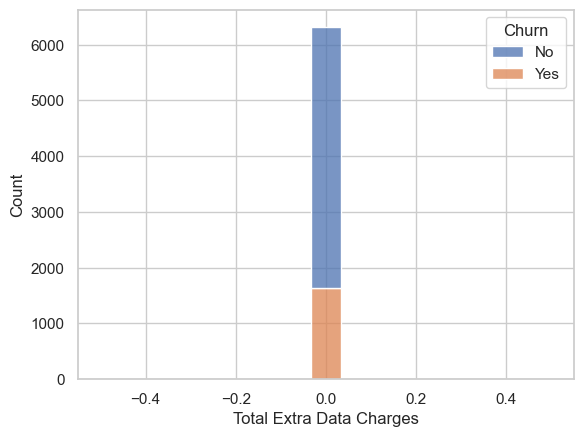

In [123]:
column_to_plot = 'Total Extra Data Charges'
sns.histplot(final_dataset[final_dataset[column_to_plot] != 0], x=column_to_plot, bins=15, hue='Churn',  multiple="stack"  )
plt.show()
print('\n')

sns.histplot(final_dataset[final_dataset[column_to_plot] == 0], x=column_to_plot, bins=15, hue='Churn',  multiple="stack" )
plt.show()
print('\n')

## Countplots for Categorical features

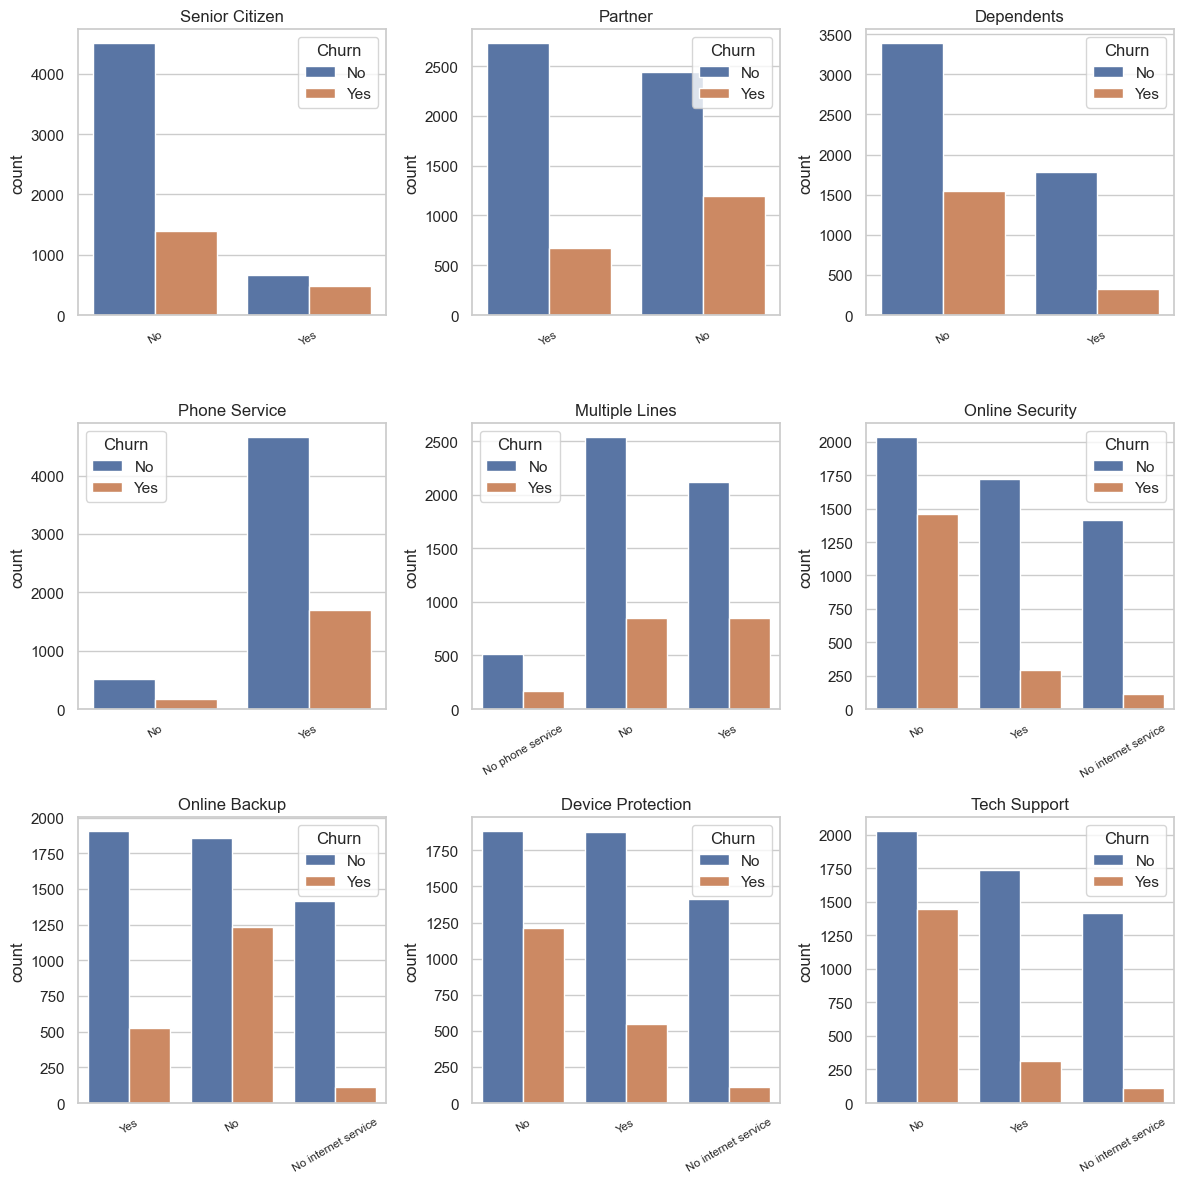

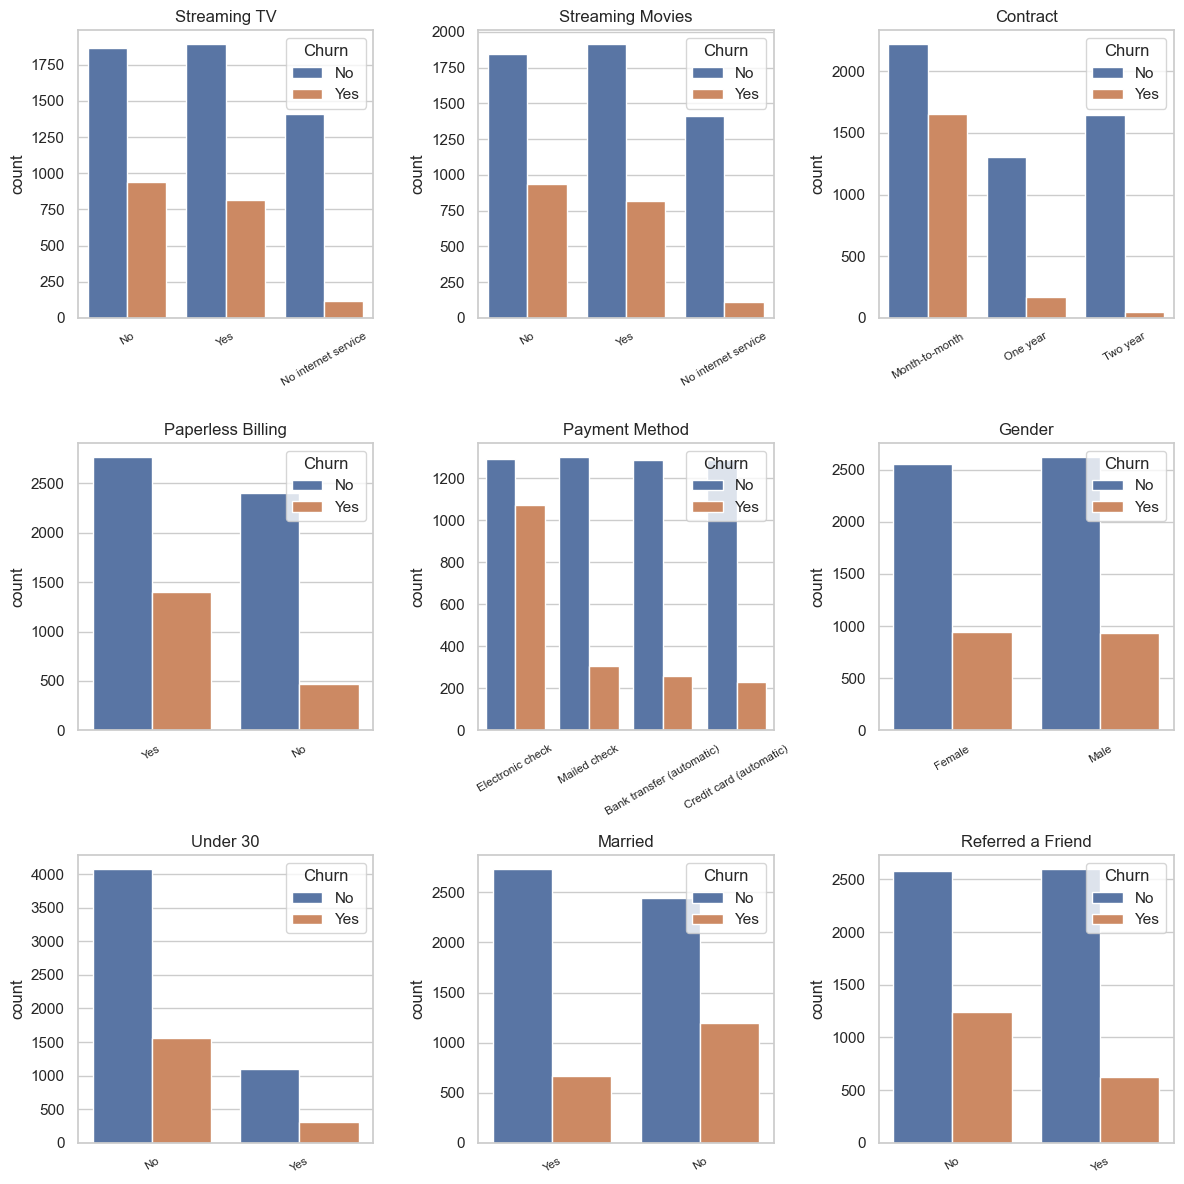

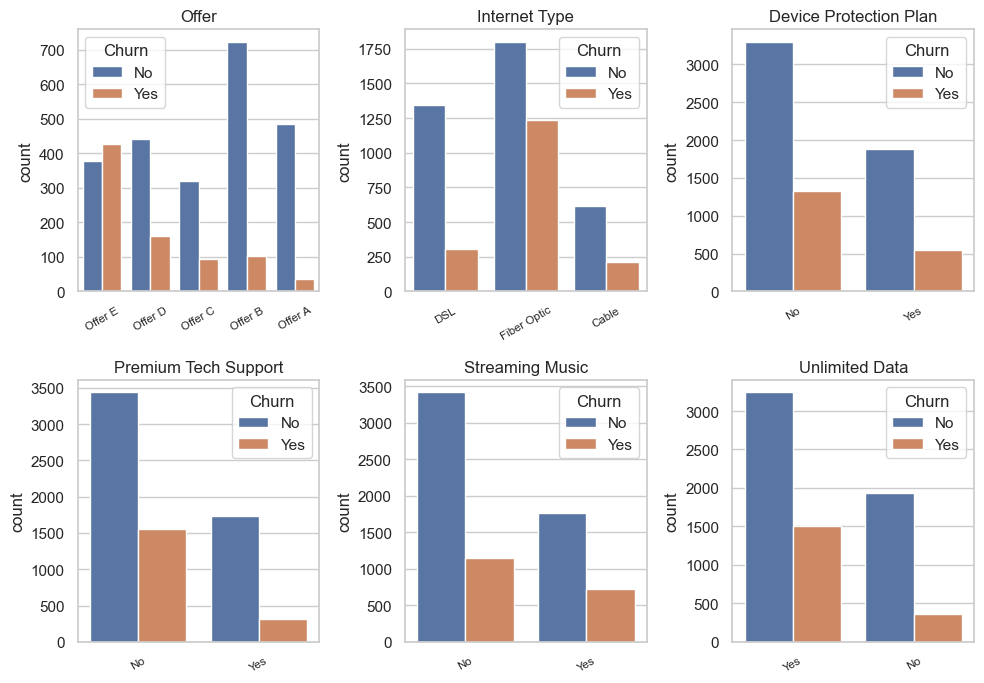

In [94]:
def plotMultiple(df, cols, size, figsize):

  fig, ax = plt.subplots(size[0], size[1], figsize=figsize)

  x=0
  y=0
  for col in cols:

    if col == 'Churn':
      continue
    sns.countplot(df, x=col, hue='Churn', ax=ax[x,y]).set(title=col, xlabel=None)
    plt.setp(ax[x, y].get_xticklabels(), rotation=30, fontsize='x-small')
    y += 1
    if y == size[1]:
      y = 0
      x += 1

  plt.tight_layout()
  plt.show()

final_df_objects = final_dataset.select_dtypes('object').drop(columns='City')
final_df_objects
plotMultiple(final_df_objects, final_df_objects.columns[:9], (3, 3), (12, 12))
plotMultiple(final_df_objects, final_df_objects.columns[9:19], (3, 3), (12, 12))
plotMultiple(final_df_objects, final_df_objects.columns[19:], (2, 3), (10, 7))

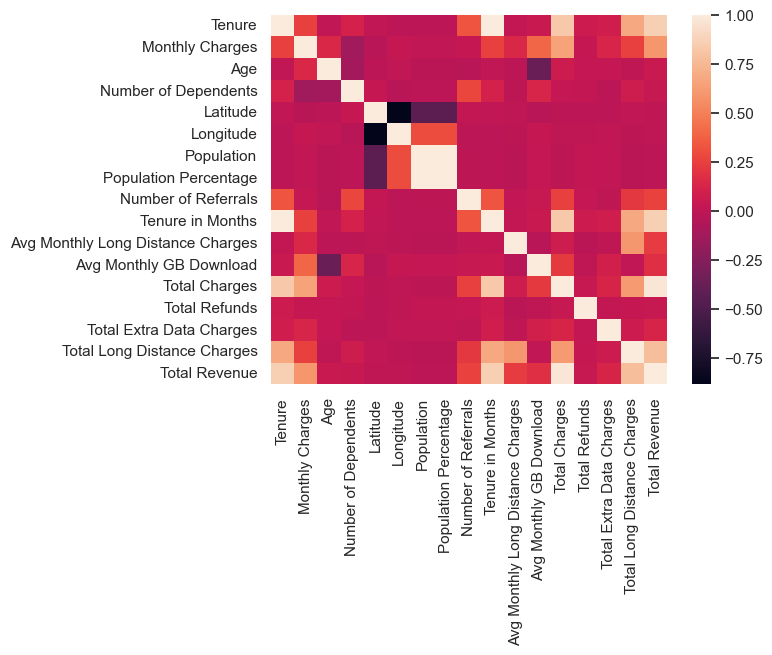

In [99]:
# final_dataset.select_dtypes(include=[int, float]).hist(bins=30, figsize=(14, 10))
sns.heatmap(final_dataset.select_dtypes(include=[int, float]).corr())
# plt.tight_layout()
# final_dataset.info()
plt.show()

## Create Heatmaps with categorical features and the class column

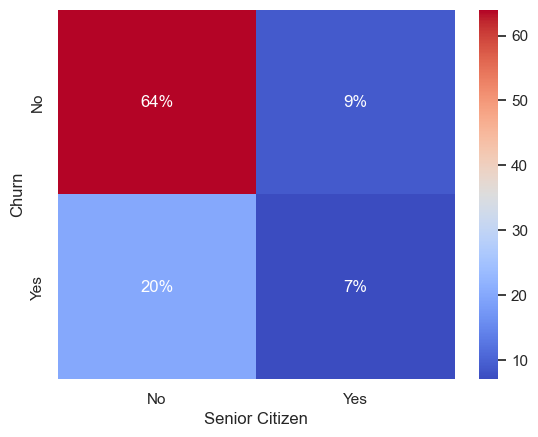

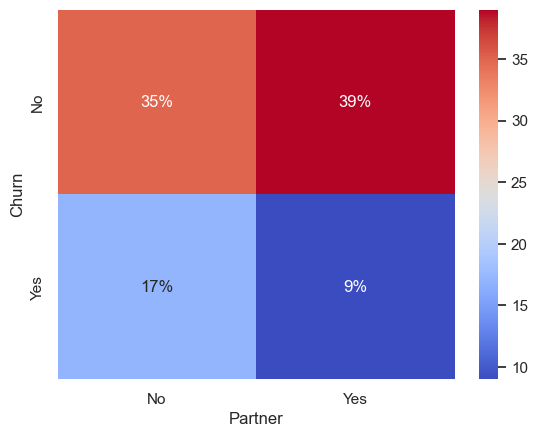

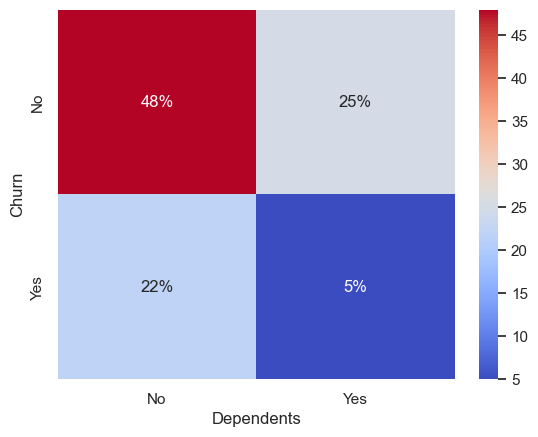

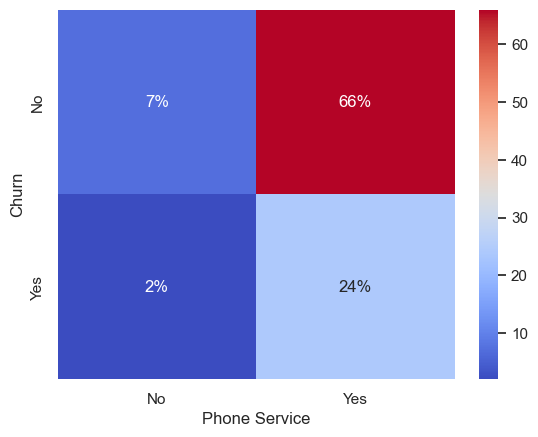

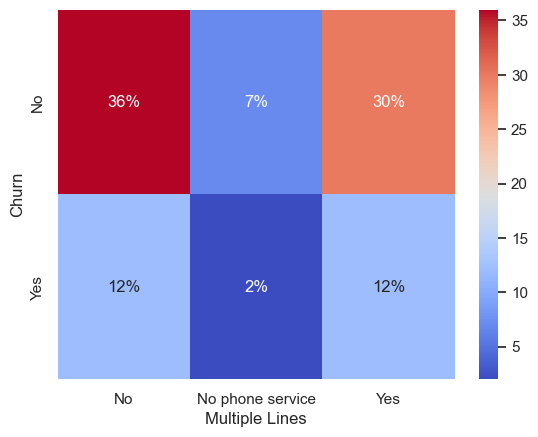

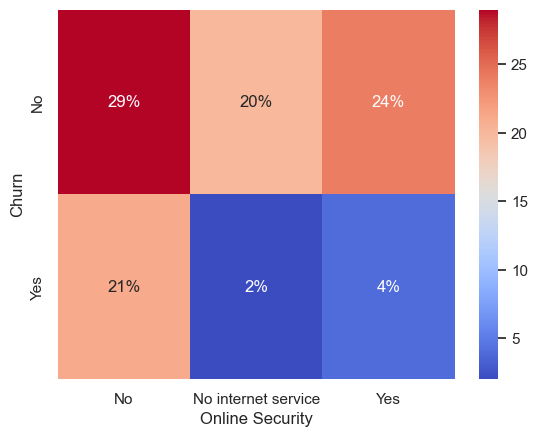

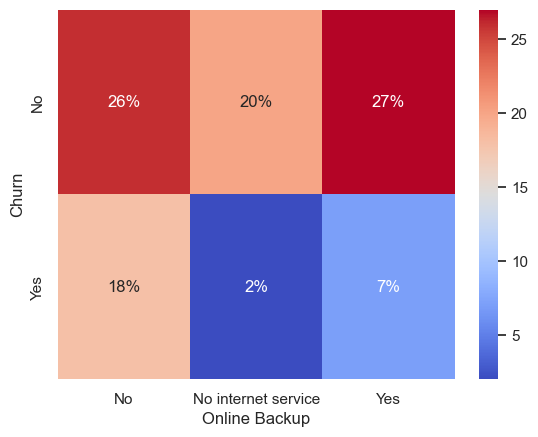

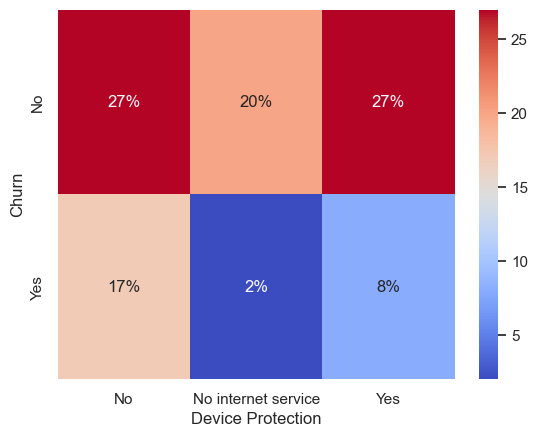

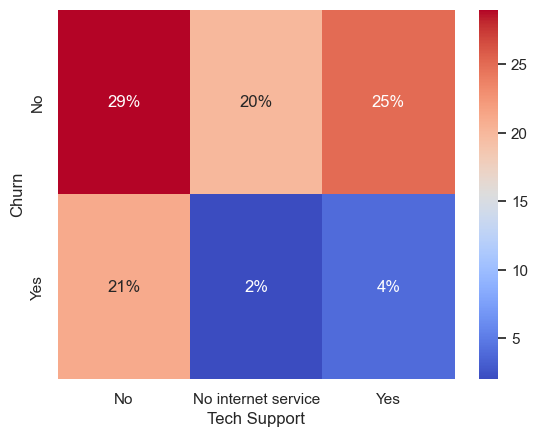

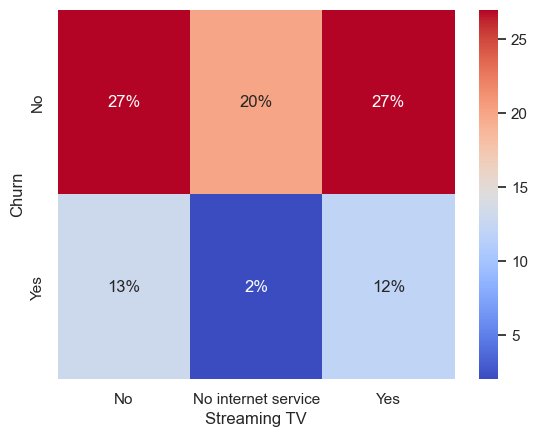

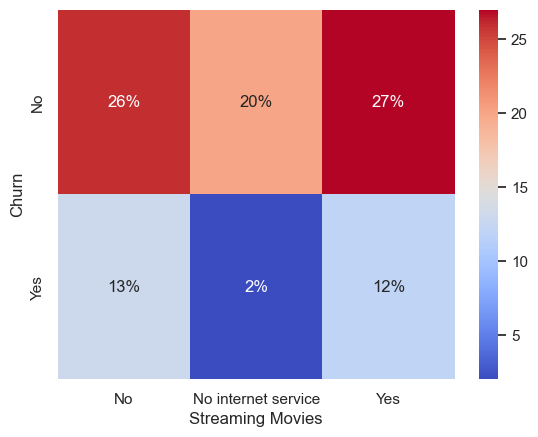

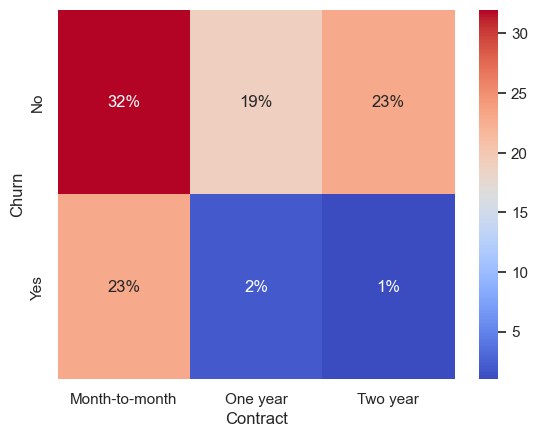

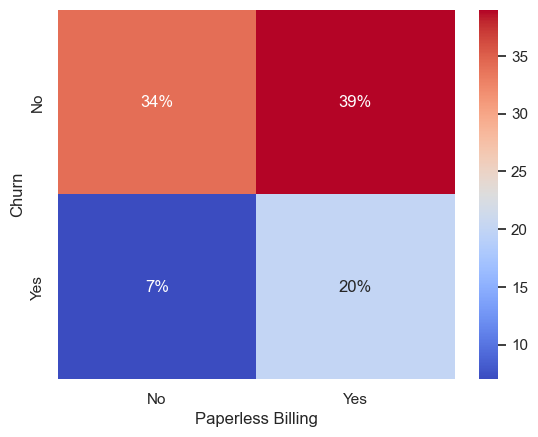

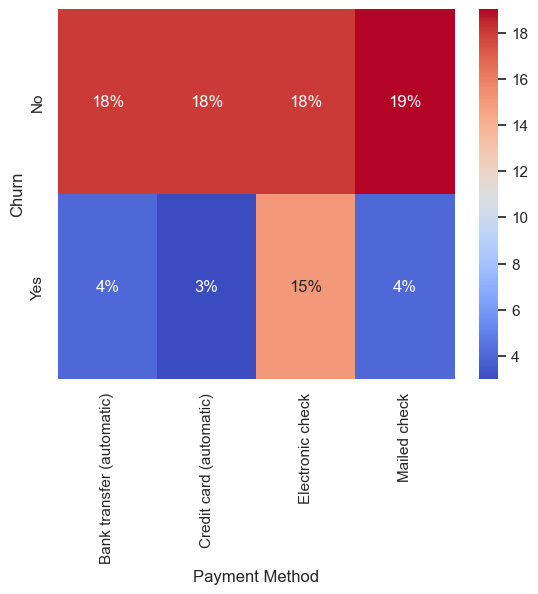

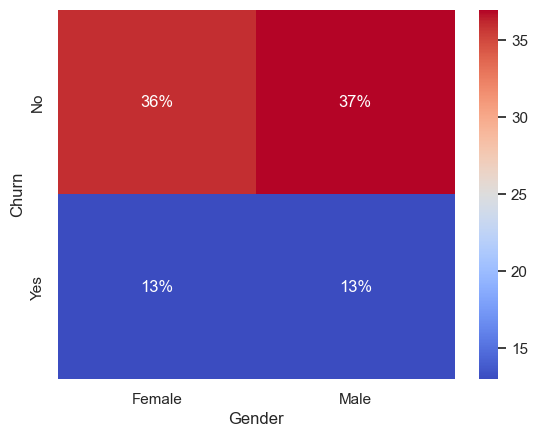

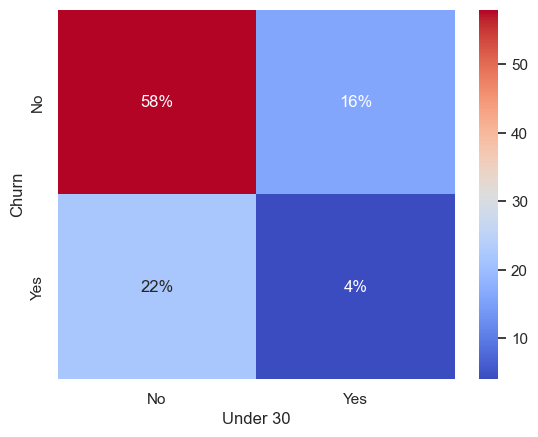

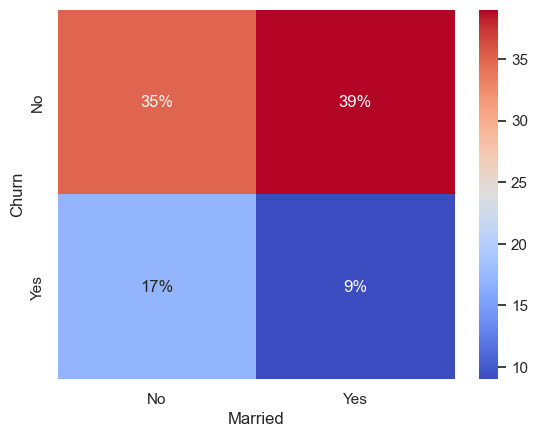

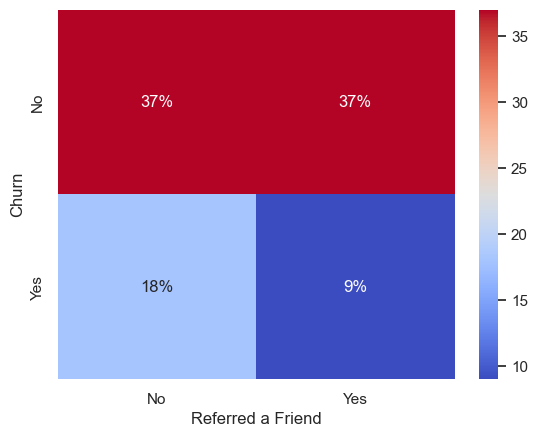

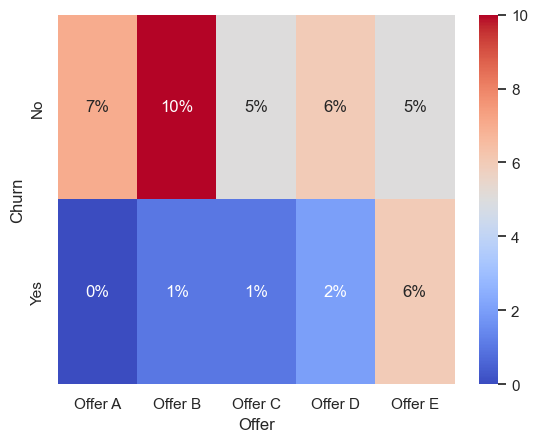

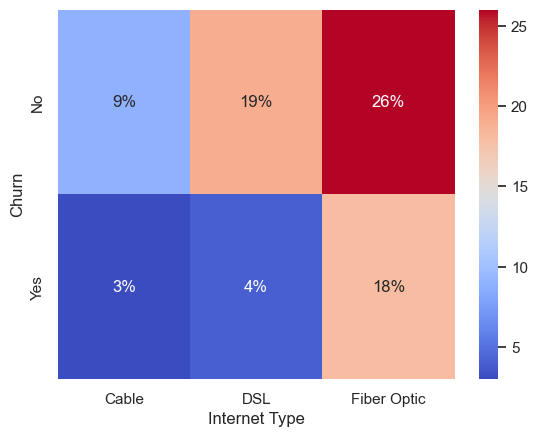

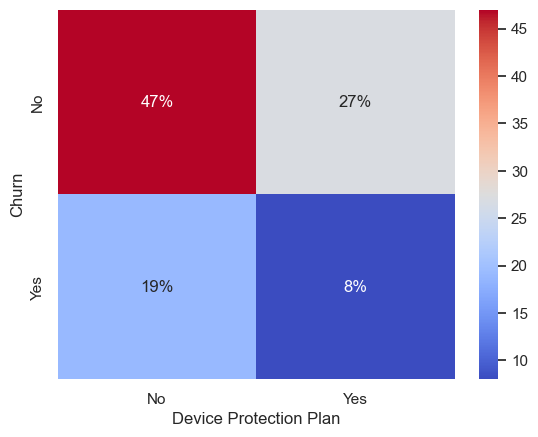

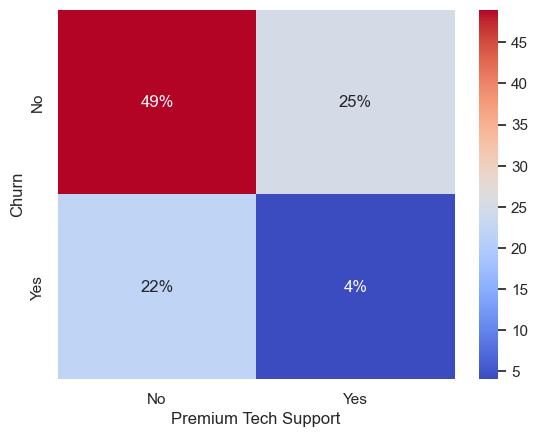

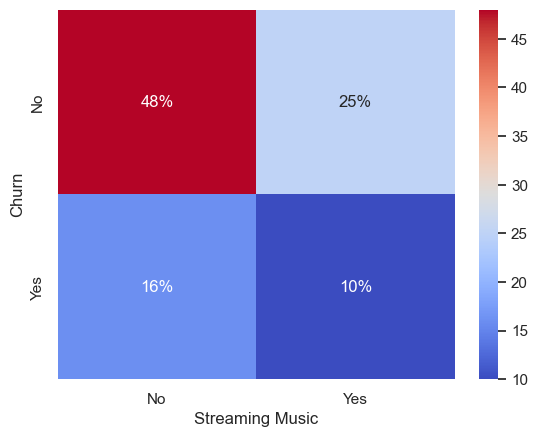

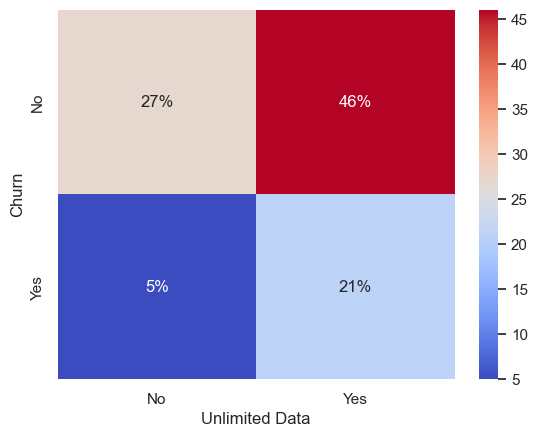

In [182]:
def createHeatmaps(df):
  for col in df.select_dtypes('object'):
    if col not in ['Churn', 'City']:
      dft = pd.crosstab(df["Churn"], df[col]).apply(func=lambda x : x / 7043 * 100).round(0)
      ax = sns.heatmap(dft, annot=True, fmt=".0f", cmap='coolwarm')
      for t in ax.texts: t.set_text(t.get_text() + "%")
      plt.show()
      print("\n")

createHeatmaps(final_dataset)

## One Hot Encoding of categorical columns

In [124]:
def onehot_enc(df):
  for col in df.columns:
    if df[col].dtype == object and col not in ['Churn', 'City']:
      onehot = OneHotEncoder(sparse_output=False, drop='if_binary')
      onehot.fit(df[[col]])
      OH_cols_train = pd.DataFrame(onehot.transform(df[[col]]),
                                   columns=onehot.get_feature_names_out(),
                                   index=df.index)
      droped_cols = df.drop(columns=col, axis=1)
      df = pd.concat([droped_cols, OH_cols_train], axis=1)
  return df

def onehot_cities(df):
  column = 'City'
  onehot = OneHotEncoder(sparse_output=False)
  onehot.fit(df[[column]])
  OH_cols_train = pd.DataFrame(onehot.transform(df[[column]]),
                                columns=onehot.get_feature_names_out(),
                                index=df.index)
  droped_cols = df.drop(columns=[column], axis=1)
  df = pd.concat([droped_cols, OH_cols_train[['City_Los Angeles', 'City_San Diego']]], axis=1)
  return df



final_dataset_oh = onehot_enc(final_dataset)
final_dataset_oh = onehot_cities(final_dataset_oh)

# Removing Similar Columns to reduce multi collinearity 
dup_cols = ['Online Security_No internet service', 'Tech Support_No internet service', 'Streaming Movies_No internet service', 'Online Backup_No internet service', 'Device Protection_No internet service']
final_dataset_oh.drop(columns=dup_cols, inplace=True)

y = final_dataset['Churn']
X = final_dataset_oh
X.drop(columns=['Churn'], inplace=True)
# X.info()


## Target Class Percentages

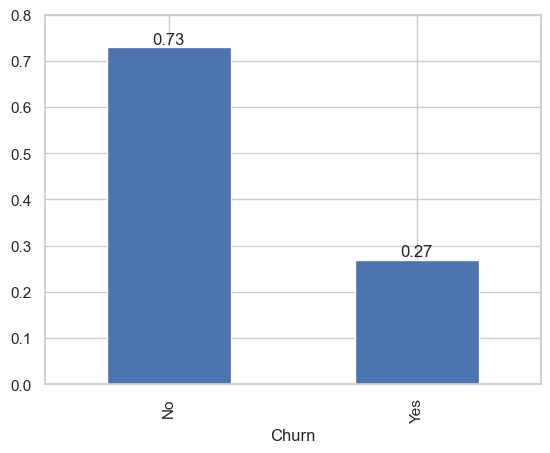

Churn
No     0.73
Yes    0.27
Name: count, dtype: float64


In [164]:
agro = final_dataset['Churn'].value_counts().map(lambda x: round(x/7043, 2))
ax = agro.plot(kind='bar')
for cnt in ax.containers:
  ax.bar_label(cnt)
plt.ylim(.0, .8)
plt.show()
print(agro)

# Train test split final dataset

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

# Scaling data for for specific models

In [129]:
scale_columns = ['Tenure', 'Monthly Charges', 'Population', 'Population Percentage', 'Number of Referrals', 'Tenure in Months',
                 'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 'Total Charges', 'Age', 'Number of Dependents',
                 'Total Long Distance Charges', 'Total Revenue', 'Total Refunds', 'Total Extra Data Charges']

X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

scaler = StandardScaler()
X_train_norm[scale_columns] = scaler.fit_transform(X_train[scale_columns])
X_test_norm[scale_columns] = scaler.transform(X_test[scale_columns])

# Utility Functions

## Plotting Confusion Matrix

In [130]:
def plot_confusion_matrix(model, X, y):
  titles_options = [
      ("Confusion matrix, without normalization", None),
      ("Normalized confusion matrix", "true"),
  ]
  for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_estimator(
          model,
          X,
          y,
          display_labels=y.unique(),
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)

      print(title)
      print(disp.confusion_matrix)

      plt.show()
      print("\n")



### Collecting classifiers to lists according to scaling

In [131]:
random_state=42
def get_classifiers():
  clf_names = ['Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'AdaBoost']
  clf_models = [DecisionTreeClassifier(random_state=random_state), RandomForestClassifier(random_state=random_state), GradientBoostingClassifier(random_state=random_state),
                XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=2, random_state=2, booster='gbtree'), AdaBoostClassifier(random_state=random_state)]
  return dict(zip(clf_names, clf_models))

def get_classifiers_for_scaled_data():
  clf_names_scaled = ['Naive Bayes', 'K-Nearest Neighbor', 'Stochastic Gradient Descent', 'Logistic Regression']
  clf_models_for_scaled = [GaussianNB(), KNeighborsClassifier(), SGDClassifier(random_state=random_state), LogisticRegression(penalty="l1", solver="saga", tol=0.1)]
  return dict(zip(clf_names_scaled, clf_models_for_scaled))

# Evaluating Default Models Without Feature Selection

### Training models

In [135]:
clfs_simple = get_classifiers()
clfs_scaled = get_classifiers_for_scaled_data()
clfs_not_scaled = get_classifiers_for_scaled_data()

# Train models that do not need scaled data
for name, model in (clfs_simple | clfs_not_scaled).items():
  print('Training ' + name)
  if name == 'XGBoost':
    start = time()
    model.fit(X_train, y_train=='Yes', eval_set=[(X_test_norm, y_test.map({'Yes': 1, 'No': 0}))])
  else:
    start = time()
    model.fit(X_train, y_train)
  print('Time to fit %.2f' % (time() - start))

# Train models that need scaled data
for name, model in clfs_scaled.items():
  print('Training ' + name)
  start = time()
  model.fit(X_train_norm, y_train)
  print('Time to fit %.2f' % (time() - start))



Training Decision Tree
Time to fit 0.20
Training Random Forest
Time to fit 1.45
Training Gradient Boosting
Time to fit 3.69
Training XGBoost
[0]	validation_0-logloss:0.52566
[1]	validation_0-logloss:0.48701
[2]	validation_0-logloss:0.47767
[3]	validation_0-logloss:0.47105
[4]	validation_0-logloss:0.46286
[5]	validation_0-logloss:0.46911
[6]	validation_0-logloss:0.45800
[7]	validation_0-logloss:0.46204
[8]	validation_0-logloss:0.45738
[9]	validation_0-logloss:0.46882
Time to fit 0.14
Training AdaBoost


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Time to fit 1.06
Training Naive Bayes
Time to fit 0.02
Training K-Nearest Neighbor
Time to fit 0.01
Training Stochastic Gradient Descent
Time to fit 0.09
Training Logistic Regression
Time to fit 0.07
Training Naive Bayes
Time to fit 0.02
Training K-Nearest Neighbor
Time to fit 0.01
Training Stochastic Gradient Descent
Time to fit 0.32
Training Logistic Regression
Time to fit 0.06


### Predicting and calculating metrics

Predicting:  Decision Tree
Decision Tree 0.7064532795990597
Predicting:  Random Forest
Random Forest 0.7338551757989098
Predicting:  Gradient Boosting
Gradient Boosting 0.7699514324834018
Predicting:  XGBoost
XGBoost 0.5
Predicting:  AdaBoost
AdaBoost 0.780826164457878
Predicting:  Naive Bayes
Naive Bayes 0.7960810147510916
Predicting:  K-Nearest Neighbor
K-Nearest Neighbor 0.7137448655351468
Predicting:  Stochastic Gradient Descent
Stochastic Gradient Descent 0.8183704048154175
Predicting:  Logistic Regression
Logistic Regression 0.7023314991345682


,scores,f1_score
Decision Tree,0.759,0.567
Random Forest,0.820,0.619
Gradient Boosting,0.839,0.672
XGBoost,0.836,0.666
AdaBoost,0.836,0.682
Naive Bayes,0.781,0.667
K-Nearest Neighbor,0.781,0.580
Stochastic Gradient Descent,0.803,0.697
Logistic Regression,0.810,0.569


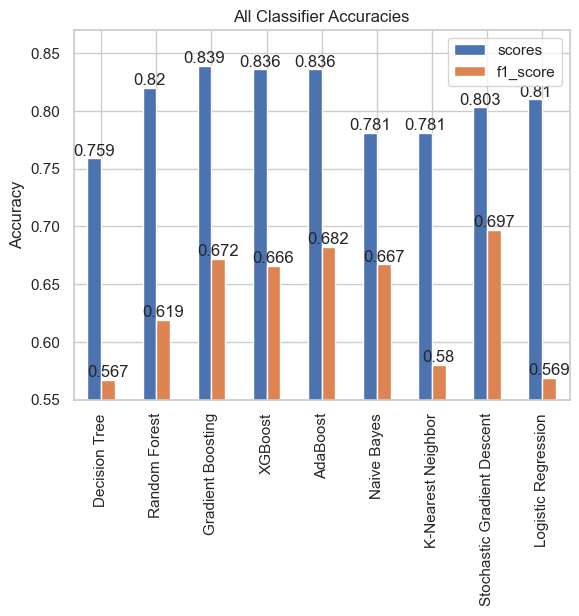

In [157]:
starting_accuracy = {}
starting_f1_score = {}
for name, model in clfs_simple.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test)
  if name == 'XGBoost':
    starting_accuracy[name] = accuracy_score(y_test=='Yes', y_pred)
    starting_f1_score[name] = f1_score(y_test=='Yes', y_pred)
  else:
    
    starting_accuracy[name] = accuracy_score(y_test, y_pred)
    starting_f1_score[name] = f1_score(y_test, y_pred, pos_label='Yes')
  
  # Needs probabilities for correct calculation
  # print(f'{name} {roc_auc_score(y_test, y_pred=="Yes")}')

for name, model in clfs_scaled.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test_norm)
  starting_accuracy[name] = accuracy_score(y_test, y_pred)
  starting_f1_score[name] = f1_score(y_test, y_pred, pos_label='Yes')
  
  # Needs probabilities for correct calculation
  # print(f'{name} {roc_auc_score(y_test, y_pred=="Yes")}')
  

# Combining Score dictionaries
df_scores = pd.DataFrame({'scores': map(lambda x: round(x, 3), starting_accuracy.values())}, 
                         index=starting_accuracy.keys()).join(round(pd.Series(starting_f1_score, name='f1_score'), 3).to_frame(), how='inner')

# Plotting Scores
ax = df_scores.plot.bar()
plt.ylim((0.55, 0.87))
plt.title("All Classifier Accuracies")
plt.ylabel('Accuracy')
for container in ax.containers:
  ax.bar_label(container)
display(df_scores)


### Comparing models that need scaling with unscaled data

Predicting:  Naive Bayes
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


,No scaled,Scaled
Naive Bayes,0.73,0.78
K-Nearest Neighbor,0.73,0.78
Stochastic Gradient Descent,0.75,0.80
Logistic Regression,0.73,0.81


[Text(0, 0, '0.78'), Text(0, 0, '0.78'), Text(0, 0, '0.8'), Text(0, 0, '0.81')]

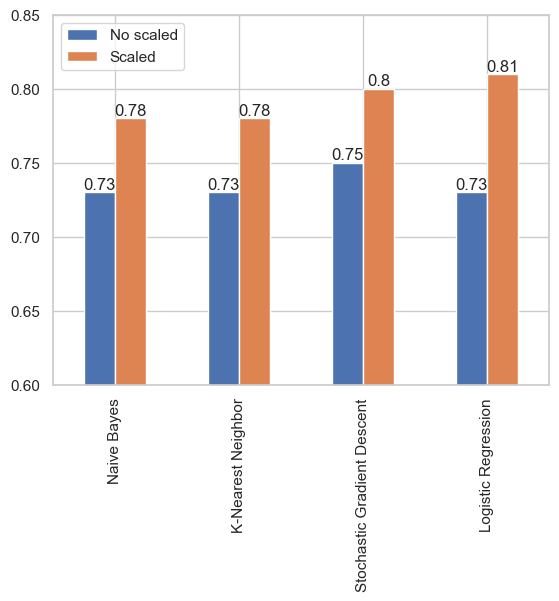

In [158]:
scores_not_normalized = {}
for name, model in clfs_not_scaled.items():
  print('Predicting: ', name)
  y_pred = model.predict(X_test)
  scores_not_normalized[name] = accuracy_score(y_test, y_pred)

df_not_normalized = pd.DataFrame({"No scaled": map(lambda x: round(x, 2), scores_not_normalized.values(), ),
                                  "Scaled": map(lambda x: round(x, 2), [starting_accuracy[name] for name in scores_not_normalized.keys()])},
                                  index=scores_not_normalized.keys())

display(df_not_normalized)

ax = df_not_normalized.plot.bar()
plt.ylim((0.6, 0.85))
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])




# Evaluating Model with SelectKBest Feature Selection method

### Utility Functions

In [517]:
def show_kbest_metric(gradient_search_cv, x_test, y_pred):
  # print(f'Best parameters for estimator: {gradient_search_cv.best_params_}')  
  
  print("Perfomance:")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Classification Report:")
  print(classification_report(y_test, y_pred, zero_division=0.0))
  print("ROC AUC Score:")
  print(roc_auc_score(y_test, gradient_search_cv.predict_proba(x_test)[:, 1]))
  print("\n")

  # Plot confusion matrix
  # plot_confusion_matrix(gradient_search_cv, x_test, y_test)

  # Plot ROC Curve
  # metrics.RocCurveDisplay.from_estimator(gradient_search_cv, x_test, y_test)


In [151]:
def show_xgb_kbest_metric(gradient_search_cv, x_test, y_pred):
  print(f'Best parameters for estimator: {gradient_search_cv.best_params_}')  

  print("XGBoost Perfomance:")
  print("Accuracy:", accuracy_score(y_test=='Yes', y_pred))
  print("Classification Report:")
  print(classification_report(y_test=='Yes', y_pred))
  print("ROC AUC Score:")
  print(roc_auc_score(y_test=='Yes', gradient_search_cv.predict_proba(x_test)[:, 1]))
  print("\n")

  # Plot confusion matrix
  # plot_confusion_matrix(gradient_search_cv, x_test, y_test=='Yes')

  # Plot ROC Curve
  # metrics.RocCurveDisplay.from_estimator(gradient_search_cv, x_test, y_test=='Yes')

In [173]:
def plot_cv_results(gscv):
  cv_results = pd.DataFrame(gscv.cv_results_)
  len(cv_results.mean_test_score)
  cv_results
  plt.figure()
  plt.xlabel("Number of features selected")
  plt.ylabel("Mean test accuracy")
  plt.errorbar(
      x=cv_results.index,
      y=cv_results.mean_test_score,
      yerr=cv_results.std_test_score
  )
  plt.show()

Initializing dictionary to hold values

In [15]:
kbest_accuracy = {}
kbest_f1_score = {}
kbest_k = {}

## Decision Tree

In [17]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

cv = StratifiedKFold(3)
estimator = make_pipeline(SelectKBest(score_func=f_classif), DecisionTreeClassifier(random_state=42))

gscv_dt_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_dt_kbest.fit(X_train, y_train)
print('Time to search: ', time() - start)
print(f"Best k features: {gscv_dt_kbest.best_params_}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search:  8.863903522491455
Best k features: {'selectkbest__k': 51}


### CV Results

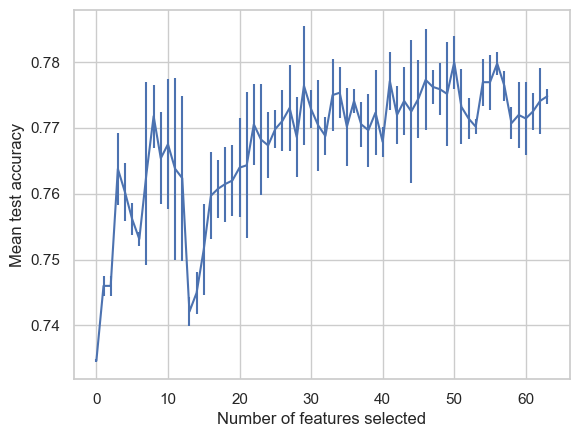

In [18]:
plot_cv_results(gscv_dt_kbest)

### Decision Tree SelectKBest Metrics

The previous run returned best value for k : 51 for SelectKBest

In [255]:
show_kbest_metric(gscv_dt_kbest, X_test, gscv_dt_kbest.predict(X_test))

kbest_accuracy['Decision Tree'] = accuracy_score(y_test, gscv_dt_kbest.predict(X_test))
kbest_f1_score['Decision Tree'] = f1_score(y_test, gscv_dt_kbest.predict(X_test), pos_label='Yes')
kbest_k['Decision Tree'] = gscv_dt_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 51}
XGBoost Perfomance:
Accuracy: 0.7572746628814763
Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.82      0.83      1035
         Yes       0.54      0.60      0.57       374

    accuracy                           0.76      1409
   macro avg       0.69      0.71      0.70      1409
weighted avg       0.77      0.76      0.76      1409

ROC AUC Score:
0.7058578108450231




## Naive Bayes

### GridSearch For Best K value and Refit

In [296]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

nb_estimator = make_pipeline(SelectKBest(score_func=f_classif), GaussianNB())
cv = StratifiedKFold(3)

gscv_nb_kbest = GridSearchCV(nb_estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring='accuracy', verbose=3)
start = time()
gscv_nb_kbest.fit(X_train, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_nb_kbest.best_params_}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 3.957ms
Best parameters found: {'selectkbest__k': 30}


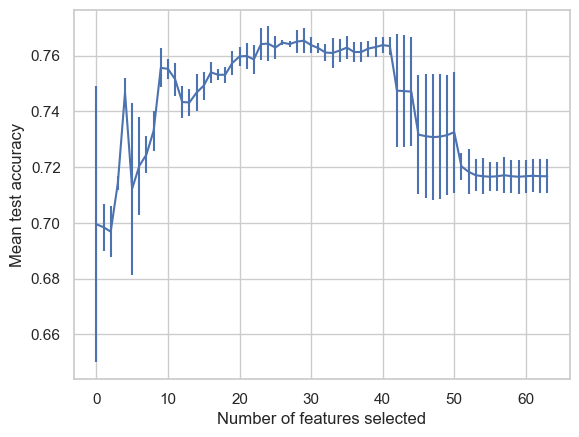

In [33]:
plot_cv_results(gscv_nb_kbest)

### Naive Bayes SelectKBest Metrics

Best value for k : 30 for SelectKBest

In [256]:
show_kbest_metric(gscv_nb_kbest, X_test, gscv_nb_kbest.predict(X_test))

kbest_accuracy['Naive Bayes'] = accuracy_score(y_test, gscv_nb_kbest.predict(X_test))
kbest_f1_score['Naive Bayes'] = f1_score(y_test, gscv_nb_kbest.predict(X_test), pos_label='Yes')
kbest_k['Naive Bayes'] = gscv_nb_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 30}
XGBoost Perfomance:
Accuracy: 0.7849538679914834
Classification Report:
              precision    recall  f1-score   support

          No       0.93      0.77      0.84      1035
         Yes       0.56      0.84      0.67       374

    accuracy                           0.78      1409
   macro avg       0.75      0.80      0.76      1409
weighted avg       0.83      0.78      0.80      1409

ROC AUC Score:
0.8729339430106693




## K-Nearest Neighbor

### GridSearch For Best K value and Refit

In [304]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

knn_estimator = make_pipeline(SelectKBest(score_func=f_classif), KNeighborsClassifier())
cv = StratifiedKFold(3)

gscv_knn_kbest = GridSearchCV(knn_estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring='accuracy', verbose=3)
start = time()
gscv_knn_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_knn_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 16.543ms
Best parameters found: {'selectkbest__k': 37}


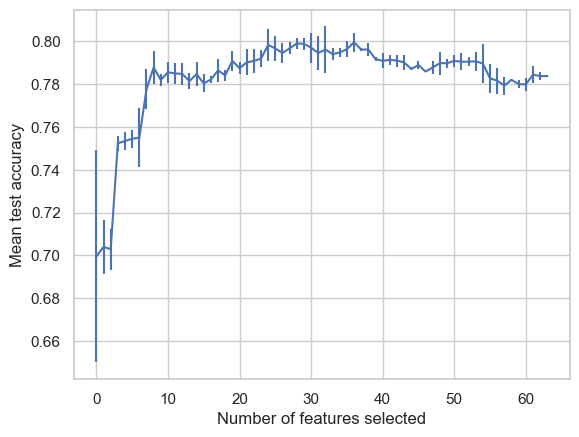

In [170]:
plot_cv_results(gscv_knn_kbest)

### KNN SelectKBest Metrics

Best value for k : 37 for SelectKBest

In [257]:
show_kbest_metric(gscv_knn_kbest, X_test_norm, gscv_knn_kbest.predict(X_test_norm))

kbest_accuracy['K-Nearest Neighbor'] = accuracy_score(y_test, gscv_knn_kbest.predict(X_test_norm))
kbest_f1_score['K-Nearest Neighbor'] = f1_score(y_test, gscv_knn_kbest.predict(X_test_norm), pos_label='Yes')
kbest_k['K-Nearest Neighbor'] = gscv_knn_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 37}
XGBoost Perfomance:
Accuracy: 0.794889992902768
Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.89      0.86      1035
         Yes       0.63      0.55      0.59       374

    accuracy                           0.79      1409
   macro avg       0.74      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409

ROC AUC Score:
0.8309721253455269




## Stochastic Gradient Descent

### GridSearch For Best K value and Refit

In [29]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), SGDClassifier(random_state=random_state))
cv = StratifiedKFold(3)

gscv_sgd_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring='accuracy', verbose=3)
start = time()
gscv_sgd_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_sgd_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 6.093ms
Best parameters found: {'selectkbest__k': 39}


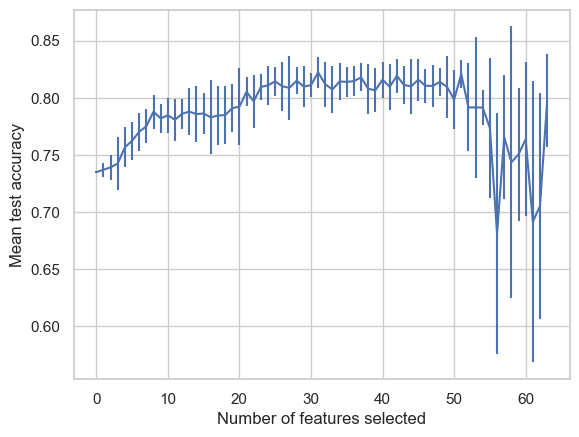

In [68]:
plot_cv_results(gscv_sgd_kbest)

### SGD SelectKBest Metrics

Best value for k : 39 for SelectKBest

In [258]:
try:
  show_kbest_metric(gscv_sgd_kbest, X_test_norm, gscv_sgd_kbest.predict(X_test_norm))
except:
  print('No predict_proba on SGD')

kbest_accuracy['Stochastic Gradient Descent'] = accuracy_score(y_test, gscv_sgd_kbest.predict(X_test_norm))
kbest_f1_score['Stochastic Gradient Descent'] = f1_score(y_test, gscv_sgd_kbest.predict(X_test_norm), pos_label='Yes')
kbest_k['Stochastic Gradient Descent'] = gscv_sgd_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 39}
XGBoost Perfomance:
Accuracy: 0.8289567068843151
Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.92      0.89      1035
         Yes       0.72      0.58      0.64       374

    accuracy                           0.83      1409
   macro avg       0.79      0.75      0.76      1409
weighted avg       0.82      0.83      0.82      1409

ROC AUC Score:
No predict_proba on SGD


## Logistic Regression

In [31]:
# Run GridSearchCV
param_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), LogisticRegression(penalty="l1", solver="saga", tol=0.1))
cv = StratifiedKFold(3)

gscv_lr_kbest = GridSearchCV(estimator, param_grid=param_grid, cv=cv, n_jobs=3, scoring='accuracy', verbose=3)
start = time()
gscv_lr_kbest.fit(X_train_norm, y_train)
end = time()
print('Time to search: %.3fs' % (end - start))
print(f"Best parameters found: {gscv_lr_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 4.450s
Best parameters found: {'selectkbest__k': 48}


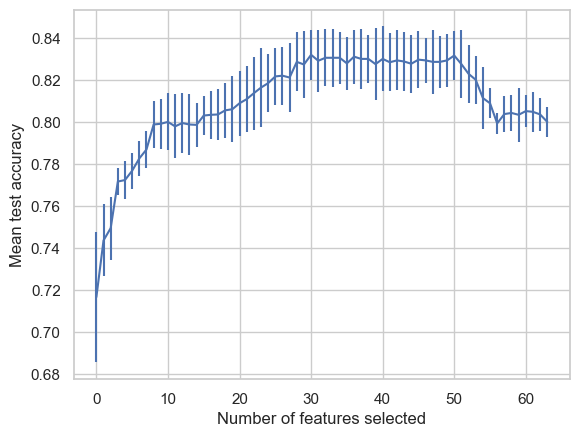

In [57]:
plot_cv_results(gscv_lr_kbest)

### LogisticRegression SelectKBest Metrics
Best value for k : 48 for SelectKBest

In [259]:
show_kbest_metric(gscv_lr_kbest, X_test_norm, gscv_lr_kbest.predict(X_test_norm))

kbest_accuracy['Logistic Regression'] = accuracy_score(y_test, gscv_lr_kbest.predict(X_test_norm))
kbest_f1_score['Logistic Regression'] = f1_score(y_test, gscv_lr_kbest.predict(X_test_norm), pos_label='Yes')
kbest_k['Logistic Regression'] = gscv_lr_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 48}
XGBoost Perfomance:
Accuracy: 0.8289567068843151
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.90      0.89      1035
         Yes       0.70      0.63      0.66       374

    accuracy                           0.83      1409
   macro avg       0.78      0.76      0.77      1409
weighted avg       0.82      0.83      0.83      1409

ROC AUC Score:
0.8967940272288099




## Random Forest

In [33]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), RandomForestClassifier(random_state=42))
cv = StratifiedKFold(3)

gscv_rfor_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_rfor_kbest.fit(X_train, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_rfor_kbest.best_params_}")


Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 44.132ms
Best parameters found: {'selectkbest__k': 54}


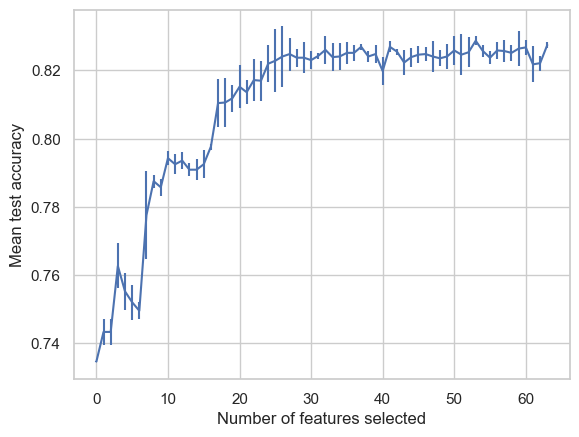

In [82]:
plot_cv_results(gscv_rfor_kbest)

### Random Forest SelectKBest Metrics
Best value for k : 54 for SelectKBest

In [260]:
show_kbest_metric(gscv_rfor_kbest, X_test, gscv_rfor_kbest.predict(X_test))

kbest_accuracy['Random Forest'] = accuracy_score(y_test, gscv_rfor_kbest.predict(X_test))
kbest_f1_score['Random Forest'] = f1_score(y_test, gscv_rfor_kbest.predict(X_test), pos_label='Yes')
kbest_k['Random Forest'] = gscv_rfor_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 54}
XGBoost Perfomance:
Accuracy: 0.830376153300213
Classification Report:
              precision    recall  f1-score   support

          No       0.86      0.92      0.89      1035
         Yes       0.73      0.57      0.64       374

    accuracy                           0.83      1409
   macro avg       0.79      0.75      0.77      1409
weighted avg       0.82      0.83      0.82      1409

ROC AUC Score:
0.8866904337492574




## Gradient Boosting

In [35]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), GradientBoostingClassifier(random_state=42))
cv = StratifiedKFold(3)

gscv_gbc_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_gbc_kbest.fit(X_train, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_gbc_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 80.826ms
Best parameters found: {'selectkbest__k': 57}


In [ ]:
plot_cv_results(gscv_gbc_kbest)

### Gradient Boosting SelectKBest Metrics
Best value for k : 57 for SelectKBest

In [261]:
show_kbest_metric(gscv_gbc_kbest, X_test, gscv_gbc_kbest.predict(X_test))

kbest_accuracy['Gradient Boosting'] = accuracy_score(y_test, gscv_gbc_kbest.predict(X_test))
kbest_f1_score['Gradient Boosting'] = f1_score(y_test, gscv_gbc_kbest.predict(X_test), pos_label='Yes')
kbest_k['Gradient Boosting'] = gscv_gbc_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 57}
XGBoost Perfomance:
Accuracy: 0.8445706174591909
Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.92      0.90      1035
         Yes       0.74      0.64      0.69       374

    accuracy                           0.84      1409
   macro avg       0.81      0.78      0.79      1409
weighted avg       0.84      0.84      0.84      1409

ROC AUC Score:
0.9094964995220749




## AdaBoost

In [37]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), AdaBoostClassifier(random_state=42, algorithm='SAMME'))
cv = StratifiedKFold(3)

gscv_ada_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_ada_kbest.fit(X_train, y_train)
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_ada_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 31.972ms
Best parameters found: {'selectkbest__k': 61}


In [ ]:
plot_cv_results(gscv_ada_kbest)

### AdaBoost SelectKBest Metrics
Best value for k : 61 for SelectKBest

In [262]:
show_kbest_metric(gscv_ada_kbest, X_test, gscv_ada_kbest.predict(X_test))

kbest_accuracy['AdaBoost'] = accuracy_score(y_test, gscv_ada_kbest.predict(X_test))
kbest_f1_score['AdaBoost'] = f1_score(y_test, gscv_ada_kbest.predict(X_test), pos_label='Yes')
kbest_k['AdaBoost'] = gscv_ada_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 61}
XGBoost Perfomance:
Accuracy: 0.830376153300213
Classification Report:
              precision    recall  f1-score   support

          No       0.88      0.89      0.89      1035
         Yes       0.69      0.66      0.67       374

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.78      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:
0.8943462760598311




## XGBoost

In [39]:
# Run GridSearchCV
para_grid = {
  'selectkbest__k' : range(1, X_train.shape[1])
}

estimator = make_pipeline(SelectKBest(score_func=f_classif), XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2, booster='gbtree'))
cv = StratifiedKFold(3)

gscv_xgb_kbest = GridSearchCV(estimator, para_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=3)
start = time()
gscv_xgb_kbest.fit(X_train, y_train=='Yes')
end = time()
print('Time to search: %.3fms' % (end - start))
print(f"Best parameters found: {gscv_xgb_kbest.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Time to search: 14.542ms
Best parameters found: {'selectkbest__k': 60}


### KBest XGBoost Metrics

In [ ]:
plot_cv_results(gscv_xgb_kbest)

In [263]:
xgb_kbest_y_pred = gscv_xgb_kbest.predict(X_test)
show_xgb_kbest_metric(gscv_xgb_kbest, X_test, xgb_kbest_y_pred)

kbest_accuracy['XGBoost'] = accuracy_score(y_test=='Yes', xgb_kbest_y_pred)
kbest_f1_score['XGBoost'] = f1_score(y_test=='Yes', xgb_kbest_y_pred)
kbest_k['XGBoost'] = gscv_xgb_kbest.best_params_['selectkbest__k']

Best parameters for estimator: {'selectkbest__k': 60}
XGBoost Perfomance:
Accuracy: 0.829666430092264
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.90      0.89      1035
        True       0.69      0.64      0.67       374

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.78      1409
weighted avg       0.83      0.83      0.83      1409

ROC AUC Score:
0.8919760262471261




## Visualize Metrics from SelectKBest Feature Selection Method

,k-best accuracy,k-best f1_score,best_k
Decision Tree,0.757275,0.565990,51
Naive Bayes,0.784954,0.673843,30
K-Nearest Neighbor,0.794890,0.585366,37
Stochastic Gradient Descent,0.828957,0.641902,39
Logistic Regression,0.828957,0.661041,48
Random Forest,0.830376,0.642750,54
Gradient Boosting,0.844571,0.686695,57
AdaBoost,0.830376,0.672154,61
XGBoost,0.829666,0.666667,60


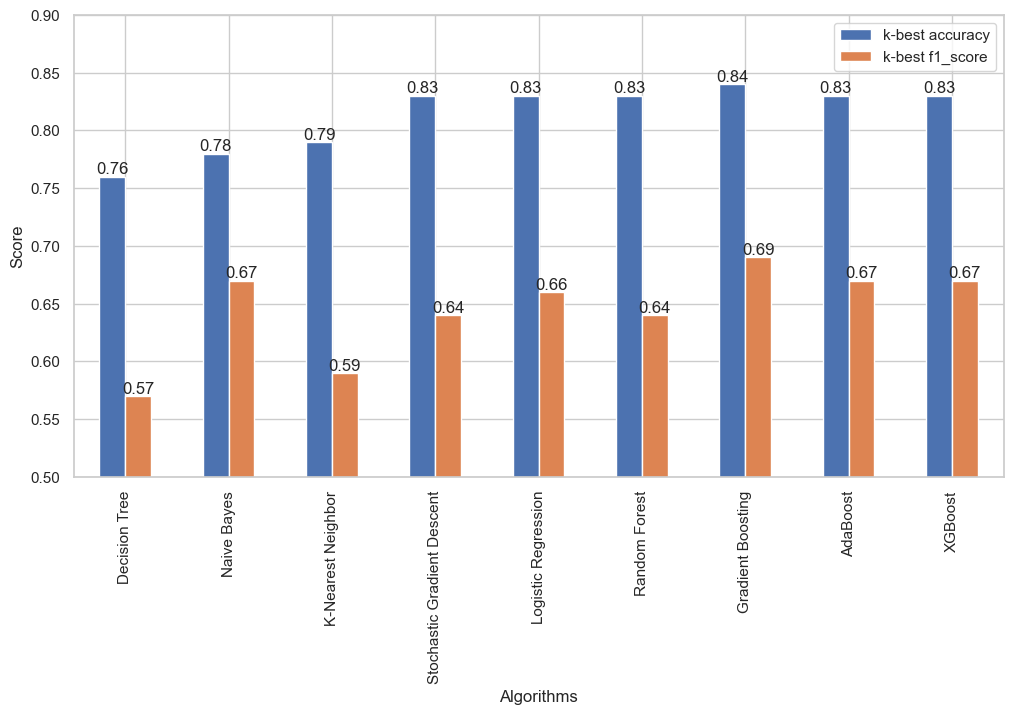

In [269]:
kbest_metrics = pd.Series(kbest_accuracy).to_frame('k-best accuracy').join(pd.Series(kbest_f1_score).to_frame('k-best f1_score'), how='inner')
kbest_metrics = kbest_metrics.join(pd.Series(kbest_k).to_frame('best_k'), how='inner')
display(kbest_metrics)
ax = kbest_metrics[['k-best accuracy', 'k-best f1_score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(12, 6))
plt.ylim(0.5, 0.90)
plt.xlabel('Algorithms')
plt.ylabel('Score')

for container in ax.containers:
  ax.bar_label(container)

# Evaluating Best Features from Recursive Feature Elimination with Cross Validation method

In [174]:
min_features_to_select = 2
rfecv_accuracy = {}
rfecv_f1_score = {}
rfecv_best_k = {}

## Creating pipelines

In [175]:
# This is used for Naive Bayes and KNN classifiers because they don't have coef_ or feature_importances_ metrics
dt_fitted = DecisionTreeClassifier(random_state=random_state).fit(X_train, y_train)


# Decision tree pipeline
rfecv_dt = RFECV(
    estimator=DecisionTreeClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
dt_rfecv_pipe = make_pipeline(rfecv_dt, DecisionTreeClassifier(random_state=random_state))


# Naive Bayes pipeline
rfecv_nb = RFECV(
    estimator=dt_fitted,
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
nb_rfecv_pipe = make_pipeline(rfecv_nb, GaussianNB())


# K-Nearest Neighbor pipeline
rfecv_knn = RFECV(
    estimator=dt_fitted,
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
knn_rfecv_pipe = make_pipeline(rfecv_knn, KNeighborsClassifier())


# Stochastic Gradient Descent pipeline
rfecv_sgd = RFECV(
    estimator=SGDClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
sgd_rfecv_pipe = make_pipeline(rfecv_sgd, SGDClassifier(random_state=random_state))


# Logistic Regression pipeline
rfecv_lr = RFECV(
    estimator=LogisticRegression(penalty="l1", solver="saga", tol=0.1, random_state=random_state),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
lr_rfecv_pipe = make_pipeline(rfecv_lr, LogisticRegression(penalty="l1", solver="saga", tol=0.1, random_state=random_state))


# Random Forest pipeline
rfecv_rf = RFECV(
    estimator=RandomForestClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rf_rfecv_pipe = make_pipeline(rfecv_rf, RandomForestClassifier(random_state=random_state))


# Gradient Boosting pipeline
rfecv_gbc = RFECV(
    estimator=GradientBoostingClassifier(random_state=random_state),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
gbc_rfecv_pipe = make_pipeline(rfecv_gbc, GradientBoostingClassifier(random_state=random_state))


# AdaBoost pipeline
rfecv_ada = RFECV(
    estimator=AdaBoostClassifier(random_state=random_state, algorithm='SAMME'),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
ada_rfecv_pipe = make_pipeline(rfecv_ada, AdaBoostClassifier(random_state=random_state, algorithm='SAMME'))


# XGBoost pipeline
rfecv_xgb = RFECV(
    estimator=XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2, booster='gbtree'),
    step=1,
    cv=StratifiedKFold(3),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
xgb_rfecv_pipe = make_pipeline(rfecv_xgb, XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2, booster='gbtree'))


pipelines_dict_non_scaled = {'Decision Tree': dt_rfecv_pipe, 'Naive Bayes': nb_rfecv_pipe, 'Random Forest': rf_rfecv_pipe, 
                             'Gradient Boosting': gbc_rfecv_pipe, 'AdaBoost': ada_rfecv_pipe, 'XGBoost': xgb_rfecv_pipe}

pipelines_dict_scaled = {'K-Nearest Neighbor': knn_rfecv_pipe, 'Stochastic Gradient Descent': sgd_rfecv_pipe, 'Logistic Regression': lr_rfecv_pipe}

## Fitting pipelines

In [176]:
full_start = time()
for name, estimator in pipelines_dict_non_scaled.items():
  print('Training ' + name)
  start = time()
  if name == 'XGBoost':    
    estimator.fit(X_train, y_train=='Yes')
  else:
    estimator.fit(X_train, y_train)
  end = time()
  print('Time to fit %.3fs' % (end - start))
  print(f'{name} fitting done!')
  

for name, estimator in pipelines_dict_scaled.items():
  print('Training ' + name)
  start = time()
  estimator.fit(X_train_norm, y_train)
  end = time()
  print('Time to fit %.3fs' % (end - start))
  print(f'{name} fitting done!')

full_end = time()
print('Time to fit %.3fs' % (full_end - full_start))

Training Decision Tree
Time to fit 12.818s
Decision Tree fitting done!
Training Naive Bayes
Time to fit 10.685s
Naive Bayes fitting done!
Training Random Forest
Time to fit 144.046s
Random Forest fitting done!
Training Gradient Boosting
Time to fit 321.057s
Gradient Boosting fitting done!
Training AdaBoost
Time to fit 97.277s
AdaBoost fitting done!
Training XGBoost
Time to fit 24.219s
XGBoost fitting done!
Training K-Nearest Neighbor
Time to fit 10.982s
K-Nearest Neighbor fitting done!
Training Stochastic Gradient Descent
Time to fit 9.875s
Stochastic Gradient Descent fitting done!
Training Logistic Regression
Time to fit 4.956s
Logistic Regression fitting done!
Time to fit 635.918s


## Making Predictions

In [289]:
for name, model in pipelines_dict_non_scaled.items():
  print('Predicting: ', name)
  rfecv_y_pred = model.predict(X_test)
  if name == 'XGBoost':
    rfecv_accuracy[name] = accuracy_score(y_test=='Yes', rfecv_y_pred)
    rfecv_f1_score[name] = f1_score(y_test=='Yes', rfecv_y_pred)
  
  else:
    rfecv_accuracy[name] = accuracy_score(y_test, rfecv_y_pred)
    rfecv_f1_score[name] = f1_score(y_test, rfecv_y_pred, pos_label='Yes')
  rfecv_best_k[name] = model['rfecv'].get_feature_names_out().shape[0]


for name, model in pipelines_dict_scaled.items():
  print('Predicting: ', name)
  rfecv_y_pred = model.predict(X_test_norm)
  rfecv_accuracy[name] = accuracy_score(y_test, rfecv_y_pred)
  rfecv_f1_score[name] = f1_score(y_test, rfecv_y_pred, pos_label='Yes')
  rfecv_best_k[name] = model['rfecv'].get_feature_names_out().shape[0]

rfecv_df_scores = pd.DataFrame({'accuracy': rfecv_accuracy,
                                'f1_score': rfecv_f1_score,
                                'rfecv_best_k':rfecv_best_k })


Predicting:  Decision Tree
Predicting:  Naive Bayes
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  AdaBoost
Predicting:  XGBoost
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


## Visualize Metrics from RFECV Feature Selection Method

,accuracy,f1_score,rfecv_best_k
Decision Tree,0.762243,0.568855,52
Naive Bayes,0.717530,0.606719,52
Random Forest,0.826118,0.639175,58
Gradient Boosting,0.845990,0.689557,30
AdaBoost,0.826828,0.664835,17
XGBoost,0.829666,0.664804,56
K-Nearest Neighbor,0.774308,0.570270,52
Stochastic Gradient Descent,0.828957,0.649199,18
Logistic Regression,0.829666,0.654179,30


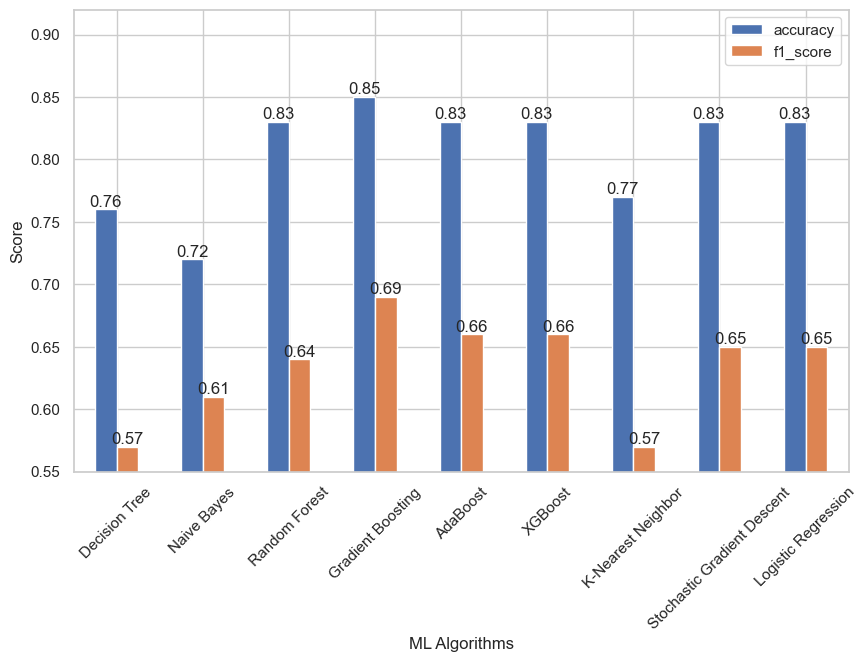

In [291]:

display(rfecv_df_scores)
ax = rfecv_df_scores[['accuracy', 'f1_score']].map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.xlabel('ML Algorithms')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend()
plt.ylim(0.55, 0.92)

for p in ax.containers:
    ax.bar_label(p)


# Hyperparameter Tuning for best models

In [370]:
accuracy_tuned = {}
f1_score_tuned = {}

## Creating Pipelines

Αν δεν εχουν τρεξει οι προηγουμενες διαδικασιες μπορουν να χρησιμοποιηθουν τα παρακατω δεδομενα για τα βελτιστα features

In [534]:
""" dt_columns = ['Dependents', 'Tenure', 'Paperless Billing', 'Monthly Charges', 'Age', 
'Married', 'Number of Dependents', 'Latitude', 'Longitude', 'Population', 
'Population Percentage', 'Number of Referrals', 'Tenure in Months', 
'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 
'Premium Tech Support', 'Streaming Music', 'Total Charges', 'Total Refunds', 
'Total Extra Data Charges', 'Total Long Distance Charges', 'Total Revenue', 
'Multiple Lines_No', 'Multiple Lines_Yes', 'Online Security_No', 
'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes', 
'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No', 
'Tech Support_Yes', 'Streaming TV_No', 'Streaming TV_No internet service', 
'Streaming TV_Yes', 'Streaming Movies_No', 'Streaming Movies_Yes', 
'Contract_Month-to-month', 'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 
'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 
'Payment Method_Mailed check', 'Gender_Male', 'Offer_No Offer', 
'Offer_Offer B', 'Offer_Offer C', 'Offer_Offer E', 'Internet Type_Cable', 
'Internet Type_DSL', 'City_Los Angeles', 'City_San Diego'] """

""" nb_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Paperless Billing', 
'Monthly Charges', 'Married', 'Number of Dependents', 'Number of Referrals', 
'Tenure in Months', 'Premium Tech Support', 'Unlimited Data', 'Total Charges', 
'Total Long Distance Charges', 'Total Revenue', 'Online Security_No', 
'Online Security_Yes', 'Online Backup_No', 'Device Protection_No', 
'Tech Support_No', 'Tech Support_Yes', 'Streaming TV_No internet service', 
'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 
'Payment Method_Electronic check', 'Offer_Offer E', 'Internet Type_Fiber Optic', 
'Internet Type_No Internet', 'City_San Diego'] """

""" knn_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Paperless Billing', 
'Monthly Charges', 'Age', 'Married', 'Number of Dependents', 'Referred a Friend', 
'Number of Referrals', 'Tenure in Months', 'Premium Tech Support', 
'Unlimited Data', 'Total Charges', 'Total Long Distance Charges', 
'Total Revenue', 'Online Security_No', 'Online Security_Yes', 
'Online Backup_No', 'Device Protection_No', 'Tech Support_No', 
'Tech Support_Yes', 'Streaming TV_No', 'Streaming TV_No internet service', 
'Streaming Movies_No', 'Contract_Month-to-month', 'Contract_One year', 
'Contract_Two year', 'Payment Method_Credit card (automatic)', 
'Payment Method_Electronic check', 'Offer_Offer A', 'Offer_Offer B', 
'Offer_Offer E', 'Internet Type_Fiber Optic', 'Internet Type_No Internet', 
'City_San Diego'] """

""" sgd_columns = ['Dependents', 'Phone Service', 'Paperless Billing', 'Monthly Charges', 
'Number of Dependents', 'Referred a Friend', 'Number of Referrals', 
'Tenure in Months', 'Avg Monthly GB Download', 'Multiple Lines_No phone service', 
'Multiple Lines_Yes', 'Online Security_Yes', 'Online Backup_Yes', 
'Tech Support_Yes', 'Contract_Month-to-month', 'Payment Method_Electronic check', 
'Offer_Offer E', 'City_San Diego'] """

""" lr_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Paperless Billing', 
'Monthly Charges', 'Age', 'Under 30', 'Married', 'Number of Dependents', 
'Population', 'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 
'Avg Monthly GB Download', 'Device Protection Plan', 'Premium Tech Support', 
'Unlimited Data', 'Total Charges', 'Total Long Distance Charges', 
'Total Revenue', 'Online Security_No', 'Online Security_Yes', 'Online Backup_No', 
'Online Backup_Yes', 'Device Protection_No', 'Device Protection_Yes', 
'Tech Support_No', 'Tech Support_Yes', 'Streaming TV_No', 
'Streaming TV_No internet service', 'Streaming TV_Yes', 'Streaming Movies_No', 
'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year', 
'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 
'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 
'Payment Method_Mailed check', 'Offer_Offer A', 'Offer_Offer B', 'Offer_Offer E', 
'Internet Type_DSL', 'Internet Type_Fiber Optic', 'Internet Type_No Internet', 
'City_San Diego'] """

'''
rfor = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Paperless Billing', 
'Monthly Charges', 'Age', 'Under 30', 'Married', 'Number of Dependents', 
'Latitude', 'Longitude', 'Population', 'Population Percentage', 
'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 
'Avg Monthly Long Distance Charges', 'Avg Monthly GB Download', 
'Device Protection Plan', 'Premium Tech Support', 'Streaming Music', 
'Unlimited Data', 'Total Charges', 'Total Refunds', 'Total Extra Data Charges', 
'Total Long Distance Charges', 'Total Revenue', 'Multiple Lines_No', 
'Multiple Lines_Yes', 'Online Security_No', 'Online Security_Yes', 
'Online Backup_No', 'Online Backup_Yes', 'Device Protection_No', 
'Device Protection_Yes', 'Tech Support_No', 'Tech Support_Yes', 
'Streaming TV_No', 'Streaming TV_Yes', 'Streaming Movies_No', 
'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year', 
'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 
'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 
'Payment Method_Mailed check', 'Gender_Male', 'Offer_No Offer', 
'Offer_Offer D', 'Offer_Offer E', 'Internet Type_Cable', 'Internet Type_DSL', 
'Internet Type_Fiber Optic', 'Internet Type_No Internet', 'City_San Diego']
'''
 
'''rfor_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure', 'Paperless Billing', 
'Monthly Charges', 'Age', 'Under 30', 'Married', 'Number of Dependents', 
'Latitude', 'Population', 'Population Percentage', 'Referred a Friend', 
'Number of Referrals', 'Tenure in Months', 'Avg Monthly GB Download', 
'Device Protection Plan', 'Premium Tech Support', 'Streaming Music', 
'Unlimited Data', 'Total Charges', 'Total Refunds', 'Total Long Distance Charges', 
'Total Revenue', 'Multiple Lines_No', 'Multiple Lines_Yes', 
'Online Security_No', 'Online Security_Yes', 'Online Backup_No', 
'Online Backup_Yes', 'Device Protection_No', 'Device Protection_Yes', 
'Tech Support_No', 'Tech Support_Yes', 'Streaming TV_No', 
'Streaming TV_No internet service', 'Streaming TV_Yes', 'Streaming Movies_No', 
'Streaming Movies_Yes', 'Contract_Month-to-month', 'Contract_One year', 
'Contract_Two year', 'Payment Method_Bank transfer (automatic)', 
'Payment Method_Credit card (automatic)', 'Payment Method_Electronic check', 
'Payment Method_Mailed check', 'Offer_Offer A', 'Offer_Offer B', 
'Offer_Offer E', 'Internet Type_DSL', 'Internet Type_Fiber Optic', 
'Internet Type_No Internet', 'City_San Diego']
'''

'''gbc_columns = ['Dependents', 'Tenure', 'Paperless Billing', 'Monthly Charges', 'Age', 
'Number of Dependents', 'Latitude', 'Longitude', 'Population', 
'Population Percentage', 'Referred a Friend', 'Number of Referrals', 
'Tenure in Months', 'Avg Monthly Long Distance Charges', 
'Avg Monthly GB Download', 'Streaming Music', 'Total Charges', 
'Total Refunds', 'Total Long Distance Charges', 'Total Revenue', 
'Multiple Lines_No', 'Online Security_No', 'Online Backup_No', 
'Tech Support_No', 'Contract_Month-to-month', 'Contract_Two year', 
'Payment Method_Electronic check', 'Offer_Offer E', 'Internet Type_Fiber Optic', 
'City_San Diego']
'''

''' ada_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure',
       'Paperless Billing', 'Monthly Charges', 'Age', 'Under 30',
       'Married', 'Number of Dependents', 'Latitude', 'Longitude',
       'Population', 'Population Percentage', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly GB Download', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming Music', 'Unlimited Data',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue',
       'Multiple Lines_No', 'Multiple Lines_No phone service',
       'Multiple Lines_Yes', 'Online Security_No', 'Online Security_Yes',
       'Online Backup_No', 'Online Backup_Yes', 'Device Protection_No',
       'Device Protection_Yes', 'Tech Support_No', 'Tech Support_Yes',
       'Streaming TV_No', 'Streaming TV_No internet service',
       'Streaming TV_Yes', 'Streaming Movies_No', 'Streaming Movies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Offer_No Offer', 'Offer_Offer A', 'Offer_Offer B',
       'Offer_Offer C', 'Offer_Offer E', 'Internet Type_Cable',
       'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Internet Type_No Internet', 'City_Los Angeles', 'City_San Diego']
'''

'''xgb_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure',
       'Paperless Billing', 'Monthly Charges', 'Age', 'Under 30',
       'Married', 'Number of Dependents', 'Latitude', 'Longitude',
       'Population', 'Population Percentage', 'Referred a Friend',
       'Number of Referrals', 'Tenure in Months',
       'Avg Monthly GB Download', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming Music', 'Unlimited Data',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue',
       'Multiple Lines_No', 'Multiple Lines_Yes', 'Online Security_No',
       'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes',
       'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No',
       'Tech Support_Yes', 'Streaming TV_No',
       'Streaming TV_No internet service', 'Streaming TV_Yes',
       'Streaming Movies_No', 'Streaming Movies_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'Payment Method_Bank transfer (automatic)',
       'Payment Method_Credit card (automatic)',
       'Payment Method_Electronic check', 'Payment Method_Mailed check',
       'Offer_No Offer', 'Offer_Offer A', 'Offer_Offer B',
       'Offer_Offer C', 'Offer_Offer E', 'Internet Type_Cable',
       'Internet Type_DSL', 'Internet Type_Fiber Optic',
       'Internet Type_No Internet', 'City_Los Angeles', 'City_San Diego']
'''

"xgb_columns = ['Senior Citizen', 'Partner', 'Dependents', 'Tenure',\n       'Paperless Billing', 'Monthly Charges', 'Age', 'Under 30',\n       'Married', 'Number of Dependents', 'Latitude', 'Longitude',\n       'Population', 'Population Percentage', 'Referred a Friend',\n       'Number of Referrals', 'Tenure in Months',\n       'Avg Monthly GB Download', 'Device Protection Plan',\n       'Premium Tech Support', 'Streaming Music', 'Unlimited Data',\n       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',\n       'Total Long Distance Charges', 'Total Revenue',\n       'Multiple Lines_No', 'Multiple Lines_Yes', 'Online Security_No',\n       'Online Security_Yes', 'Online Backup_No', 'Online Backup_Yes',\n       'Device Protection_No', 'Device Protection_Yes', 'Tech Support_No',\n       'Tech Support_Yes', 'Streaming TV_No',\n       'Streaming TV_No internet service', 'Streaming TV_Yes',\n       'Streaming Movies_No', 'Streaming Movies_Yes',\n       'Contract_Month-to-month',

### Prepare Train and Test data for each model

In [473]:
X_train_dt_best = X_train[pipelines_dict_non_scaled['Decision Tree']['rfecv'].get_feature_names_out()]
X_test_dt_best = X_test[pipelines_dict_non_scaled['Decision Tree']['rfecv'].get_feature_names_out()]

X_train_nb_best = X_train[gscv_nb_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_nb_best = X_test[gscv_nb_kbest.best_estimator_['selectkbest'].get_feature_names_out()]

X_train_knn_best = X_train_norm[gscv_knn_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_knn_best = X_test_norm[gscv_knn_kbest.best_estimator_['selectkbest'].get_feature_names_out()]

X_train_sgd_best = X_train_norm[pipelines_dict_scaled['Stochastic Gradient Descent']['rfecv'].get_feature_names_out()]
X_test_sgd_best = X_test_norm[pipelines_dict_scaled['Stochastic Gradient Descent']['rfecv'].get_feature_names_out()]

X_train_lr_best = X_train_norm[gscv_lr_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_lr_best = X_test_norm[gscv_lr_kbest.best_estimator_['selectkbest'].get_feature_names_out()]

X_train_rfor_best = X_train[gscv_rfor_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_rfor_best = X_test[gscv_rfor_kbest.best_estimator_['selectkbest'].get_feature_names_out()]

X_train_gbc_best = X_train[pipelines_dict_non_scaled['Gradient Boosting']['rfecv'].get_feature_names_out()]
X_test_gbc_best = X_test[pipelines_dict_non_scaled['Gradient Boosting']['rfecv'].get_feature_names_out()]

X_train_ada_best = X_train[gscv_ada_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_ada_best = X_test[gscv_ada_kbest.best_estimator_['selectkbest'].get_feature_names_out()]

X_train_xgb_best = X_train[gscv_xgb_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
X_test_xgb_best = X_test[gscv_xgb_kbest.best_estimator_['selectkbest'].get_feature_names_out()]
 

### Train Test pairs for each estimator type

In [474]:
train_test_pairs = {
  'Decision Tree': (X_train_dt_best, X_test_dt_best), 
  'Naive Bayes': (X_train_nb_best, X_test_nb_best), 
  'Random Forest': (X_train_rfor_best, X_test_rfor_best), 
  'Gradient Boosting': (X_train_gbc_best, X_test_gbc_best),
  'AdaBoost': (X_train_ada_best, X_test_ada_best), 
  'XGBoost': (X_train_xgb_best, X_test_xgb_best),
  'K-Nearest Neighbor': (X_train_knn_best, X_test_knn_best), 
  'Stochastic Gradient Descent': (X_train_sgd_best, X_test_sgd_best), 
  'Logistic Regression': (X_train_lr_best, X_test_lr_best)
}

### Creating GridSearchCV and RandomizedSearchCV for each estimator

In [368]:
# Decision tree
parameter_dt = {
    'max_depth': [None, 2, 5, 6, 7, 10, 15, 20],
    'criterion': ['log_loss', 'gini'],
    'min_samples_leaf': [1, 10, 15, 16, 17, 20],
    'min_samples_split': [2, 5, 10, 20, 40],
    'splitter':['best','random']
}
gscv_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), parameter_dt, n_jobs=-1, cv=StratifiedKFold(3), verbose=1)


# Naive Bayes
params_NB = {
    'var_smoothing': np.logspace(0,-10, num=100)
}

gscv_nb = GridSearchCV(GaussianNB(), params_NB, n_jobs=-1, cv=StratifiedKFold(3), verbose=1)


# K-Nearest Kneighbor
params_KNN = {
    'n_neighbors': np.arange(10, 30),
    'leaf_size': [14, 15, 16, 20, 25],
    'p': [1, 2]
}

gscv_knn = GridSearchCV(KNeighborsClassifier(), params_KNN, verbose=1, n_jobs=-1, cv=StratifiedKFold(3))


# Stochastic Gradient Descent pipeline
params_SGD = [{
    'penalty': ['elasticnet'],
    'l1_ratio': np.append(np.linspace(0, 1, num=5),0.15),
    }, 
    {
      'learning_rate' : ['optimal', 'adaptive', 'invscaling']
    }]

gscv_sgd = GridSearchCV(SGDClassifier(random_state=42), params_SGD, verbose=1, n_jobs=-1, cv=StratifiedKFold(3))

# Logistic Regression pipeline
params_LR = {
    'solver' : ['lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C' : [100, 10, 1.0, 0.1, 0.01]
    }
    

gscv_lr = GridSearchCV(LogisticRegression(random_state=42), params_LR, verbose=1, n_jobs=-1, cv=StratifiedKFold(3))


# Random Forest pipeline
parameter_RFOR = {
    'n_estimators': [160, 165],
    'criterion': ['log_loss', 'gini'],
    'min_samples_split': [2, 10, 12, 15, 20],
    'min_samples_leaf': [1, 10, 12, 15, 20],
    'max_depth': [10, 15, 20],
    'max_features': ['sqrt']
}

rscv_rfor = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), param_distributions=parameter_RFOR, n_iter=25, verbose=1, cv=StratifiedKFold(3)
)


# Gradient Boosting pipeline
parameter_GBC = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'min_samples_leaf' : np.linspace(0.1, 0.5, 5, endpoint=True),
    'min_samples_split' : np.linspace(0.1, 1.0, 10, endpoint=True),
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
    'max_features' : list(range(1,X_train_gbc_best.shape[1]))
}

rscv_gbc = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42), param_distributions=parameter_GBC, n_iter=25, verbose=3, cv=StratifiedKFold(3)
)


# AdaBoost pipeline
parameter_ADA = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [4, 8, 16, 32, 64, 100, 200],
    'algorithm' : ['SAMME']
}

rscv_ada = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42), param_distributions=parameter_ADA, n_iter=25, verbose=1, cv=StratifiedKFold(3)
)



# XGBoost pipeline
parameter_XGB = {
    'learning_rate' : [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators' : [16, 32, 64, 100],
    'max_depth' : np.linspace(10, 100, 10, dtype=int, endpoint=True),
}

gscv_xgb = GridSearchCV(
    XGBClassifier(tree_method="hist", eval_metric='logloss', early_stopping_rounds=None, random_state=2),
    param_grid=parameter_XGB,
    verbose=1,
    cv=StratifiedKFold(3),
    scoring='accuracy'
)


search_cv = {'Decision Tree': gscv_dt, 'Naive Bayes': gscv_nb, 'Random Forest': rscv_rfor, 
            'Gradient Boosting': rscv_gbc, 'AdaBoost': rscv_ada, 'XGBoost': gscv_xgb,
            'K-Nearest Neighbor': gscv_knn, 'Stochastic Gradient Descent': gscv_sgd, 'Logistic Regression': gscv_lr}



## Tuning Hyperparameters

In [369]:
full_start = time()
for name, search in search_cv.items():
  print('Tuning: ', name)
  start = time()
  if name == 'XGBoost':
    search.fit(train_test_pairs[name][0], y_train=='Yes')
  else:
    search.fit(train_test_pairs[name][0], y_train)
  end = time()
  print(f'Time tuning {name} : {(end-start)}s')

  print(f'Best params for {name} : {search.best_params_}')

full_end = time()
print(f'Full Tuning time {full_end-full_start}s')

Tuning:  Decision Tree
Fitting 3 folds for each of 960 candidates, totalling 2880 fits


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Time tuning Decision Tree : 45.79061317443848s
Best params for Decision Tree : {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}
Tuning:  Naive Bayes
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Time tuning Naive Bayes : 2.539628505706787s
Best params for Naive Bayes : {'var_smoothing': np.float64(3.1992671377973845e-10)}
Tuning:  Random Forest
Fitting 3 folds for each of 25 candidates, totalling 75 fits


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Time tuning Random Forest : 89.76972913742065s
Best params for Random Forest : {'n_estimators': 165, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'criterion': 'gini'}
Tuning:  Gradient Boosting
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=0.01, max_depth=80, max_features=3, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100;, score=0.735 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=80, max_features=3, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100;, score=0.735 total time=   0.2s
[CV 3/3] END learning_rate=0.01, max_depth=80, max_features=3, min_samples_leaf=0.30000000000000004, min_samples_split=0.4, n_estimators=100;, score=0.734 total time=   0.2s
[CV 1/3] END learning_rate=0.5, max_depth=30, max_features=8, min_samples_leaf=0.1, min_samples_split=1.0, n_estimators=64;, score=0.834 total time=   0.2s
[CV 2/3] END learning_r

c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Time tuning K-Nearest Neighbor : 54.53800129890442s
Best params for K-Nearest Neighbor : {'leaf_size': 14, 'n_neighbors': np.int64(26), 'p': 1}
Tuning:  Stochastic Gradient Descent
Fitting 3 folds for each of 9 candidates, totalling 27 fits


c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
6 fits failed out of a total of 27.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\futura\Desktop\πτυχιακη 2\ipynb\.venv\lib\site-packages\sklearn\linear_model\_stochastic

Time tuning Stochastic Gradient Descent : 0.4570026397705078s
Best params for Stochastic Gradient Descent : {'l1_ratio': np.float64(0.75), 'penalty': 'elasticnet'}
Tuning:  Logistic Regression
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Time tuning Logistic Regression : 1.572838306427002s
Best params for Logistic Regression : {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
Full Tuning time 648.9614677429199s


## Making predictions with best hyperparameters

In [373]:
for name, model in search_cv.items():
  print('Predicting: ', name)  
  if name == 'XGBoost':
    y_pred_tuned = model.predict(train_test_pairs[name][1])
    accuracy_tuned[name] = accuracy_score(y_test=='Yes', y_pred_tuned)    
    f1_score_tuned[name] = f1_score(y_test=='Yes', y_pred_tuned)    
  else:
    y_pred_tuned = model.predict(train_test_pairs[name][1])
    accuracy_tuned[name] = accuracy_score(y_test, y_pred_tuned)
    f1_score_tuned[name] = f1_score(y_test, y_pred_tuned, pos_label='Yes')
  end = time()
  


Predicting:  Decision Tree
Predicting:  Naive Bayes
Predicting:  Random Forest
Predicting:  Gradient Boosting
Predicting:  AdaBoost
Predicting:  XGBoost
Predicting:  K-Nearest Neighbor
Predicting:  Stochastic Gradient Descent
Predicting:  Logistic Regression


## Visualize Metrics after Tuning

,accuracy,f1_score
Decision Tree,0.816182,0.609351
Naive Bayes,0.783534,0.672395
Random Forest,0.830376,0.640602
Gradient Boosting,0.836764,0.669540
AdaBoost,0.833925,0.673184
XGBoost,0.826828,0.657303
K-Nearest Neighbor,0.819021,0.623338
Stochastic Gradient Descent,0.831796,0.654015
Logistic Regression,0.831086,0.670360


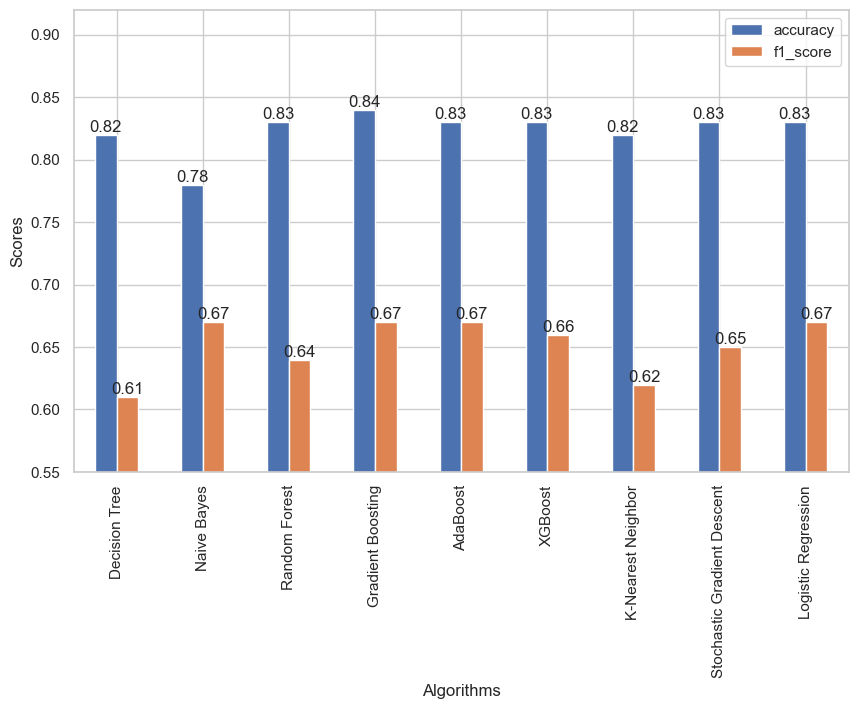

In [394]:
tuned_scores = pd.DataFrame({'accuracy': accuracy_tuned.values(), 'f1_score': f1_score_tuned.values()}, index=f1_score_tuned.keys())
display(tuned_scores)
ax = tuned_scores.map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.55, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)



In [428]:
accuracy_comparison = pd.DataFrame({'Before tuning SelectKBest': kbest_metrics['k-best accuracy'],
                                    'Before tuning RFECV': rfecv_df_scores['accuracy'],                                    
                                    'After tuning': tuned_scores['accuracy']}, index=tuned_scores.index)

f1_score_comparison = pd.DataFrame({'Before tuning SelectKBest': kbest_metrics['k-best f1_score'],
                                    'Before tuning RFECV': rfecv_df_scores['f1_score'],                                    
                                    'After tuning': tuned_scores['f1_score']}, index=tuned_scores.index )
rounding = lambda x: round(x, 2)

accuracy_comparison.index.name='Algorithms'
f1_score_comparison.index.name='Algorithms'

accuracy_comparison.to_csv('accuracy_comp.csv')
f1_score_comparison.to_csv('accuracy_comp.csv')

display(accuracy_comparison)
display(f1_score_comparison)

,Before tuning SelectKBest,Before tuning RFECV,After tuning
Algorithms,,,
Decision Tree,0.757275,0.762243,0.816182
Naive Bayes,0.784954,0.717530,0.783534
Random Forest,0.830376,0.826118,0.830376
Gradient Boosting,0.844571,0.845990,0.836764
AdaBoost,0.830376,0.826828,0.833925
XGBoost,0.829666,0.829666,0.826828
K-Nearest Neighbor,0.794890,0.774308,0.819021
Stochastic Gradient Descent,0.828957,0.828957,0.831796
Logistic Regression,0.828957,0.829666,0.831086


,Before tuning SelectKBest,Before tuning RFECV,After tuning
Algorithms,,,
Decision Tree,0.565990,0.568855,0.609351
Naive Bayes,0.673843,0.606719,0.672395
Random Forest,0.642750,0.639175,0.640602
Gradient Boosting,0.686695,0.689557,0.669540
AdaBoost,0.672154,0.664835,0.673184
XGBoost,0.666667,0.664804,0.657303
K-Nearest Neighbor,0.585366,0.570270,0.623338
Stochastic Gradient Descent,0.641902,0.649199,0.654015
Logistic Regression,0.661041,0.654179,0.670360


### Plotting

<BarContainer object of 4 artists>
<BarContainer object of 4 artists>
<BarContainer object of 4 artists>
<BarContainer object of 5 artists>
<BarContainer object of 5 artists>
<BarContainer object of 5 artists>


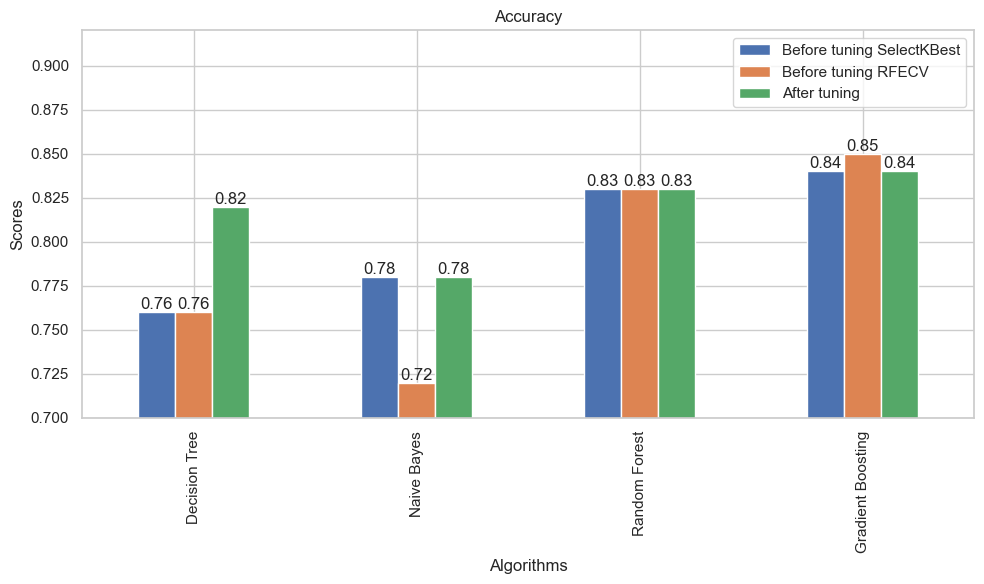

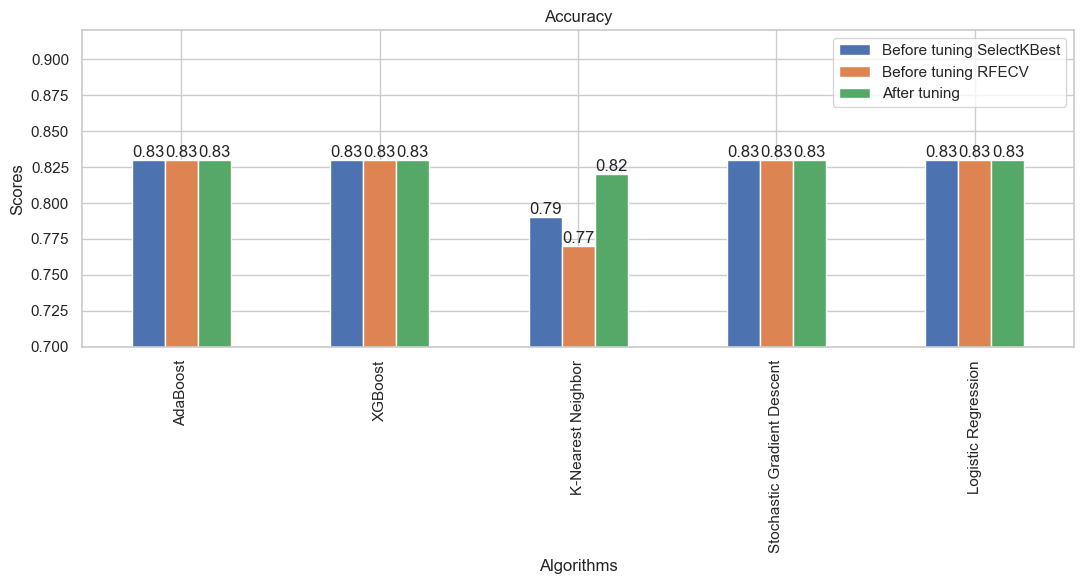

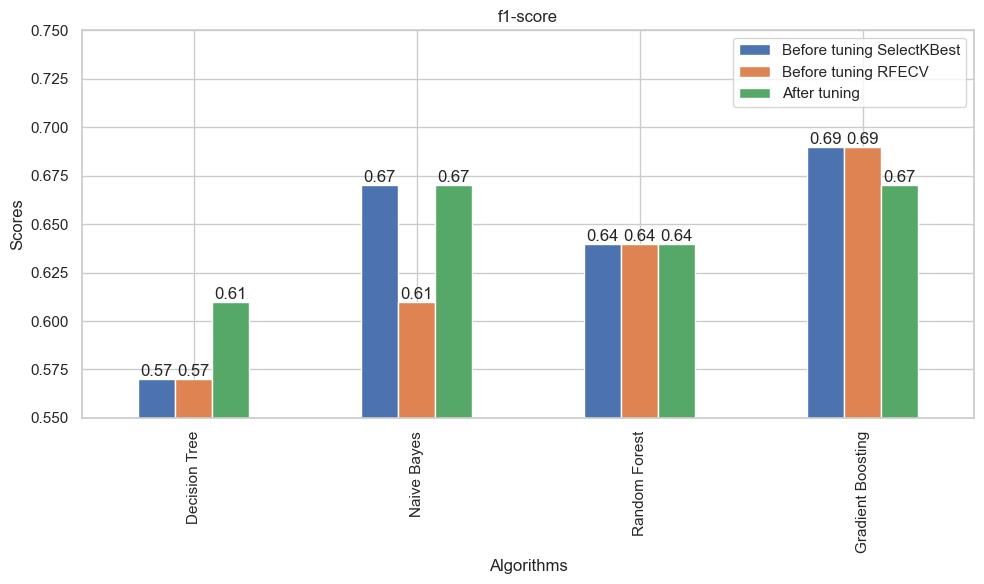

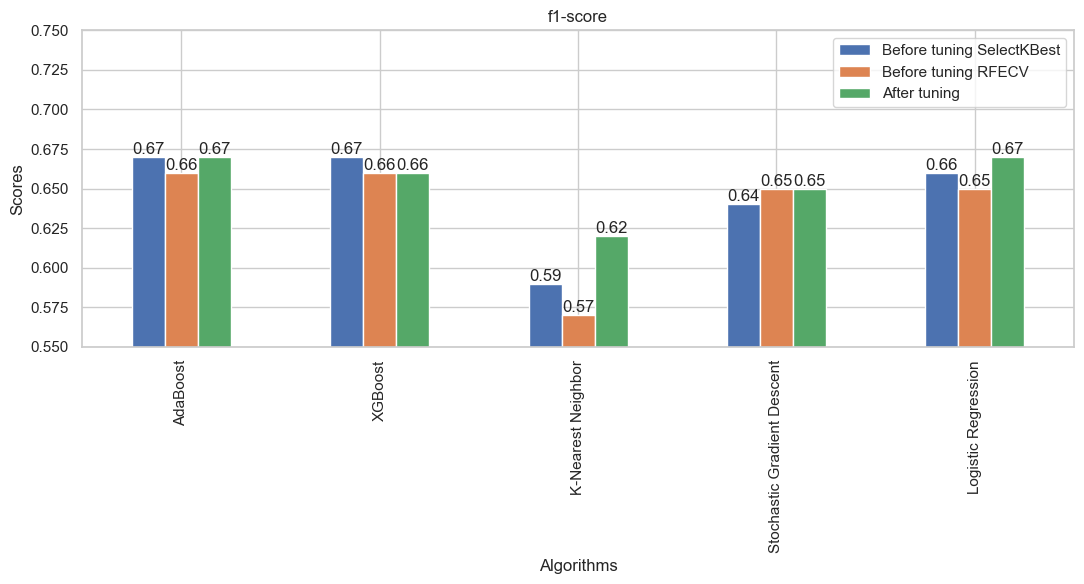

In [436]:
ax = accuracy_comparison.iloc[:4, ].map(rounding).plot(kind='bar',figsize=(10, 6))
plt.ylim(0.70, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.title('Accuracy')

for container in ax.containers:
  ax.bar_label(container)

plt.tight_layout()


ax = accuracy_comparison.iloc[4:].map(rounding).plot(kind='bar',figsize=(11, 6))
plt.ylim(0.70, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.title('Accuracy')

for container in ax.containers:
  ax.bar_label(container)

plt.tight_layout()



ax = f1_score_comparison.iloc[:4, ].map(rounding).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.55, 0.75)
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.title('f1-score')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()


ax = f1_score_comparison.iloc[4:].map(rounding).plot(kind='bar', figsize=(11, 6))
plt.ylim(0.55, 0.75)
plt.xlabel('Algorithms')
plt.ylabel('Scores')
plt.title('f1-score')

for idx, container in enumerate(ax.containers):
  print(container)
  ax.bar_label(container)

plt.tight_layout()


# Ensemble Testing

In [479]:
adaboost_accuracy = {}
adaboost_f1_score = {}
bagging_accuracy = {}
bagging_f1_score = {}

## Testing AdaBoost with different simple models and best features

In [460]:
estimators_dict = {
  'Decision Tree': DecisionTreeClassifier(random_state=random_state),
  'Naive Bayes' : GaussianNB(),
  'Logistic Regression': LogisticRegression(C=1, penalty="l2", solver="newton-cg"),
  'Stochastic Gradient Descent' : SGDClassifier(random_state=random_state)
}



In [489]:
full_start = time()
for name, estimator in estimators_dict.items():
  adaboost_params = {    
    'n_estimators' : [10, 50, 70, 100, 200, 250],  
    'learning_rate' : [ 0.15, 0.25, 0.5, 0.75, 1.0]
  }
  simple_grid_search = GridSearchCV(AdaBoostClassifier(estimator=estimator, algorithm='SAMME', random_state=random_state), adaboost_params, n_jobs=-1, cv=StratifiedKFold(5))
  start = time()
  simple_grid_search.fit(train_test_pairs[name][0], y_train)
  end = time()
  print(f'AdaBoost with {name} - best params: {simple_grid_search.best_params_}')
  print(f'Time Evaluating AdaBoost with {name}: {end-start}') 

  y_pred_ada = simple_grid_search.predict(train_test_pairs[name][1])
  adaboost_accuracy[name] = accuracy_score(y_test, y_pred_ada)
  adaboost_f1_score[name] = f1_score(y_test, y_pred_ada, pos_label='Yes')

  show_kbest_metric(simple_grid_search, train_test_pairs[name][1], simple_grid_search.predict(train_test_pairs[name][1]))



full_end = time()
print(f'Processing Time: {full_end-full_start}')

AdaBoost with Decision Tree - best params: {'learning_rate': 0.15, 'n_estimators': 10}
Time Evaluating AdaBoost with Decision Tree: 6.372934579849243
Best parameters for estimator: {'learning_rate': 0.15, 'n_estimators': 10}
Perfomance:
Accuracy: 0.7622427253371186
Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.83      0.84      1035
         Yes       0.55      0.57      0.56       374

    accuracy                           0.76      1409
   macro avg       0.70      0.70      0.70      1409
weighted avg       0.77      0.76      0.76      1409

ROC AUC Score:
0.7024090004908419


AdaBoost with Naive Bayes - best params: {'learning_rate': 0.15, 'n_estimators': 70}
Time Evaluating AdaBoost with Naive Bayes: 28.16849637031555
Best parameters for estimator: {'learning_rate': 0.15, 'n_estimators': 70}
Perfomance:
Accuracy: 0.8161816891412349
Classification Report:
              precision    recall  f1-score   support

        

,Adaboost accuracy,Adaboost f1-score
Decision Tree,0.762243,0.562092
Naive Bayes,0.816182,0.684531
Logistic Regression,0.734564,0.000000
Stochastic Gradient Descent,0.832505,0.674033


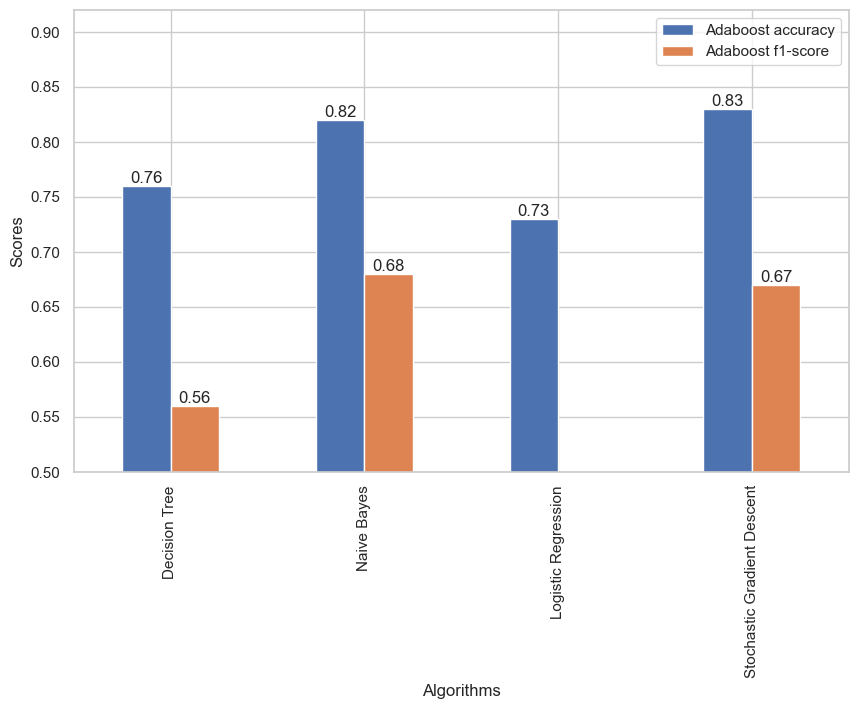

In [499]:
adaboost_scores = pd.DataFrame({'Adaboost accuracy': adaboost_accuracy,
                                'Adaboost f1-score': adaboost_f1_score}, index=adaboost_accuracy.keys())


display(adaboost_scores)
ax = adaboost_scores.map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.50, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)

In [528]:
full_start = time()
for name, estimator in estimators_dict.items():
  if name != 'Logistic Regression':
    continue
  bagging_params_scaled = {  
    'n_estimators': [10, 20, 50, 70, 100, 150, 200]    
  }
  bagging_grid_search = GridSearchCV(BaggingClassifier(estimator=estimator, random_state=random_state), bagging_params_scaled, n_jobs=-1, cv=StratifiedKFold(5))  
  print('Fitting : ' + name)
  start = time()
  bagging_grid_search.fit(train_test_pairs[name][0], y_train)
  end = time()
  print(f'\nBagging with {name} - best params: {bagging_grid_search.best_params_}')
  print(f'Time Evaluating Bagging with {name}: {end-start}\n') 

  y_pred_ada = bagging_grid_search.predict(train_test_pairs[name][1])
  bagging_accuracy[name] = accuracy_score(y_test, y_pred_ada)
  bagging_f1_score[name] = f1_score(y_test, y_pred_ada, pos_label='Yes')

  show_kbest_metric(bagging_grid_search, train_test_pairs[name][1], bagging_grid_search.predict(train_test_pairs[name][1]))



full_end = time()
print(f'Processing Time: {full_end-full_start}')


Fitting : Logistic Regression

Bagging with Logistic Regression - best params: {'n_estimators': 200}
Time Evaluating Bagging with Logistic Regression: 37.82329177856445

Perfomance:
Accuracy: 0.8275372604684174
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.90      0.88      1035
         Yes       0.69      0.64      0.66       374

    accuracy                           0.83      1409
   macro avg       0.78      0.77      0.77      1409
weighted avg       0.82      0.83      0.83      1409

ROC AUC Score:
0.8966157741093802


Processing Time: 38.148627519607544


,Bagging accuracy,Bagging f1-score
Decision Tree,0.823279,0.657497
Naive Bayes,0.784244,0.673118
Logistic Regression,0.827537,0.662031
Stochastic Gradient Descent,0.831796,0.659971


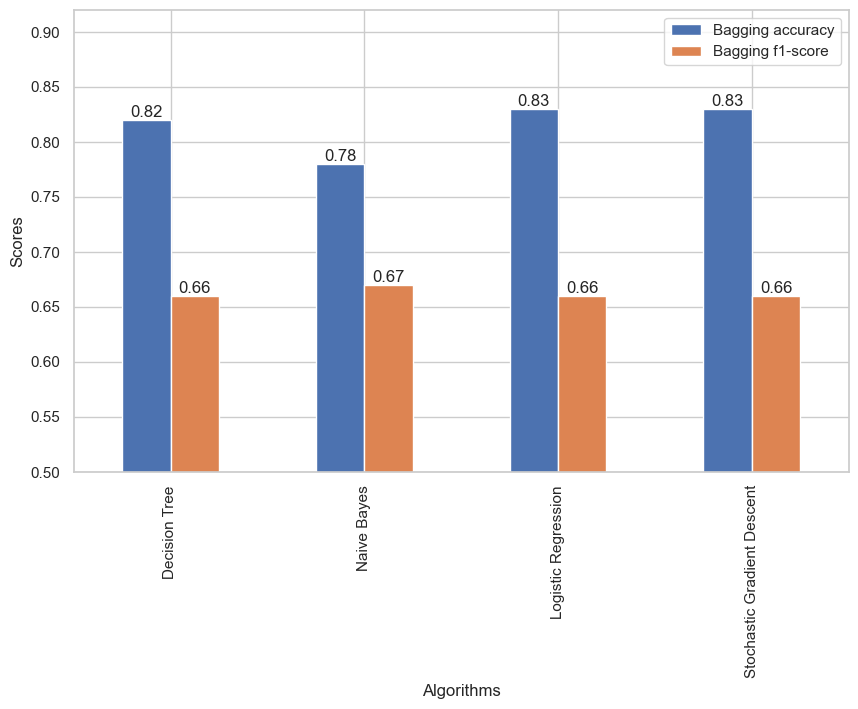

In [500]:
bagging_scores = pd.DataFrame({'Bagging accuracy': bagging_accuracy,
                                'Bagging f1-score': bagging_f1_score}, index=bagging_accuracy.keys())


display(bagging_scores)
ax = bagging_scores.map(lambda x: round(x, 2)).plot(kind='bar', figsize=(10, 6))
plt.ylim(0.50, 0.92)
plt.xlabel('Algorithms')
plt.ylabel('Scores')

for container in ax.containers:
  ax.bar_label(container)

In [452]:
gboosting_params = {
  'estimator' : [DecisionTreeClassifier(random_state=random_state), GaussianNB()],
  'n_estimators': [20, 40]
}

BaggingClassifier
simple_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=random_state), gboosting_params, n_jobs=-1, cv=StratifiedKFold(5))
simple_grid_search.fit(X_train_dt_best, y_train)
print(simple_grid_search.best_params_)

show_kbest_metric(simple_grid_search, X_test_dt_best, simple_grid_search.predict(X_test_dt_best))

{'estimator': DecisionTreeClassifier(random_state=42), 'n_estimators': 100}
Best parameters for estimator: {'estimator': DecisionTreeClassifier(random_state=42), 'n_estimators': 100}
XGBoost Perfomance:
Accuracy: 0.8232789212207239
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.89      0.88      1035
         Yes       0.68      0.63      0.66       374

    accuracy                           0.82      1409
   macro avg       0.77      0.76      0.77      1409
weighted avg       0.82      0.82      0.82      1409

ROC AUC Score:
0.8827662817432639




In [ ]:
boosting_params = {
  'estimator' : [DecisionTreeClassifier(random_state=random_state), GaussianNB()],
  'n_estimators': [20, 50, 70, 100]
}


simple_grid_search = GridSearchCV(BaggingClassifier(random_state=random_state), boosting_params, n_jobs=-1, cv=StratifiedKFold(5))
simple_grid_search.fit(X_train_dt_best, y_train)
print(simple_grid_search.best_params_)

show_kbest_metric(simple_grid_search, X_test_dt_best, simple_grid_search.predict(X_test_dt_best))

# Training the best estimator on the whole dataset

Perfomance:
Accuracy: 0.836007383217379
Classification Report:
              precision    recall  f1-score   support

          No       0.87      0.91      0.89      5174
         Yes       0.72      0.62      0.67      1869

    accuracy                           0.84      7043
   macro avg       0.80      0.77      0.78      7043
weighted avg       0.83      0.84      0.83      7043

ROC AUC Score:
0.8972252504238275


Confusion matrix, without normalization
[[4728  446]
 [ 709 1160]]


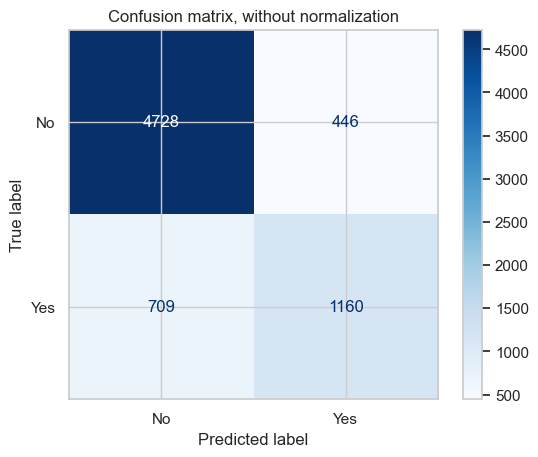



Normalized confusion matrix
[[0.91379977 0.08620023]
 [0.37934724 0.62065276]]


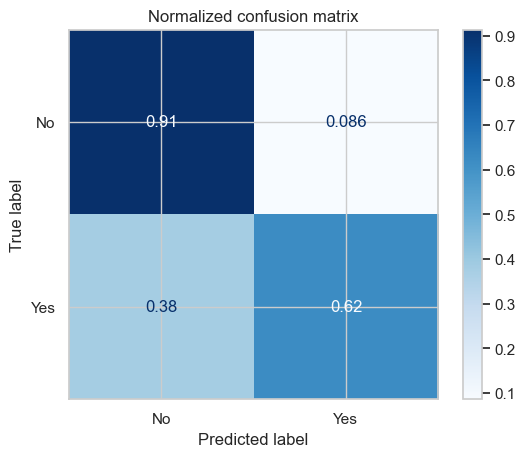

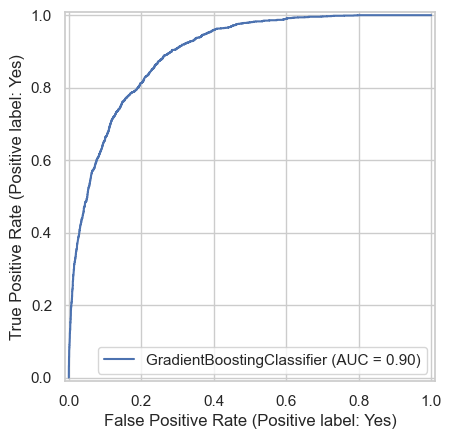

In [542]:
best_gboosting_params = search_cv['Gradient Boosting'].best_estimator_.get_params()
best_gradient_boosting = GradientBoostingClassifier(random_state=random_state)
best_gradient_boosting.set_params(**best_gboosting_params)
best_gradient_boosting.fit(X, y)
best_y_pred = best_gradient_boosting.predict(X)

print("Perfomance:")
print("Accuracy:", accuracy_score(y, best_y_pred))
print("Classification Report:")
print(classification_report(y, best_y_pred, zero_division=0.0))
print("ROC AUC Score:")
print(roc_auc_score(y, best_gradient_boosting.predict_proba(X)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_gradient_boosting, X, y)

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_gradient_boosting, X, y)



## Feature Importance For best estimators

In [547]:
gbc_feat_importance = pd.DataFrame({'features': best_gradient_boosting.feature_names_in_, 'importance': best_gradient_boosting.feature_importances_})
print(gbc_feat_importance.sort_values(by='importance', ascending=False).to_string())

                                    features  importance
17                          Tenure in Months    0.231299
32                        Online Security_No    0.192264
16                       Number of Referrals    0.170824
50           Payment Method_Electronic check    0.084426
6                            Monthly Charges    0.048819
10                      Number of Dependents    0.048628
3                                     Tenure    0.038551
62                 Internet Type_No Internet    0.035929
45                   Contract_Month-to-month    0.024660
21                      Premium Tech Support    0.012715
38                           Tech Support_No    0.011980
9                                    Married    0.011104
0                             Senior Citizen    0.010027
60                         Internet Type_DSL    0.009154
5                          Paperless Billing    0.008648
24                             Total Charges    0.008567
11                             

In [15]:
best_bag = BaggingClassifier(estimator=LogisticRegression(C=10, penalty="l2", solver="liblinear"), n_estimators=200, random_state=random_state)
best_bag.fit(X, y)
bag_y_pred = best_bag.predict(X)

print("Perfomance:")
print("Accuracy:", accuracy_score(y, bag_y_pred))
print("Classification Report:")
print(classification_report(y, bag_y_pred, zero_division=0.0))
print("ROC AUC Score:")
print(roc_auc_score(y, best_bag.predict_proba(X)[:, 1]))
print("\n")

# Plot confusion matrix
plot_confusion_matrix(best_bag, X, y)

# Plot ROC Curve
RocCurveDisplay.from_estimator(best_bag, X, y)



KeyboardInterrupt: 

In [14]:
print(pd.DataFrame({'feature': best_bag.feature_names_in_, 'coef' :best_bag.estimators_[1].coef_[0]}).sort_values(by='coef', ascending=False).to_string())

                                     feature          coef
15                         Referred a Friend  5.875671e-01
9                                    Married  5.039799e-01
1                                    Partner  5.039799e-01
64                            City_San Diego  3.751644e-01
45                   Contract_Month-to-month  3.458394e-01
5                          Paperless Billing  3.082713e-01
2                                 Dependents  2.699336e-01
50           Payment Method_Electronic check  2.444853e-01
32                        Online Security_No  2.179008e-01
30           Multiple Lines_No phone service  1.823556e-01
38                           Tech Support_No  1.740089e-01
58                             Offer_Offer E  1.385593e-01
34                          Online Backup_No  1.158413e-01
59                       Internet Type_Cable  1.112276e-01
55                             Offer_Offer B  8.223664e-02
22                           Streaming Music  7.932081e-